#

# **DELE CA1 Part A**
###### --> By Tan Eu Zin, 2415927, From DAAA/FT/2B/22

#

# **Imports** 
###### - Importing all necessary libraries and tools (mostly from keras)

In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast 
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop  
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np
import random

# 

# **Setting random seed**
###### - Setting a random seed for this assignment to ensure consistent results.
###### - Doing so using tensorflow as most of the code is handling tensorflow.

In [2]:
# random seed set to 42
tf.random.set_seed(42)

#

# **Importing Data**
###### - All the data is in the Dataset_CA1_PartA folder
###### - Inside the folder there is train, test and validation folders
###### - Each folder containes labels, which are labelled folders 
###### - Each folder then contains all related photos in that class

In [3]:
# define the paths to main data folders
main_dir = './PartA_Dataset/Dataset_CA1_PartA'

# get the train, test and validation directories
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')
val_dir = os.path.join(main_dir, 'validation')

#

# **Cleaning Data**
###### - Labelled folders in train, test and validation folders are all inconsistently named.
###### - Their folder names are manually changed to follow a fix format.
###### - Furthermore, in the train folder, the 'Pumpkin' and 'Tomato' folders were incorrectly labelled. 
###### - Their labels were switched so as to fit the pictures inside the folder. 

#

# **Observing the dataset**
###### - Plotting bar charts for each label in each folder of the data.
###### - Check if there are any imbalances / unfairness in the data. 
###### - E.g one class having significantly more / less data compared to others.
###### - If this issue is present, solve it.

In [4]:
# defining a function to plot number of data in each label 

def plot_label_counts(directory):
    
    # getting the labels
    class_names = sorted(os.listdir(directory))
    label_counts = {}

    # counting the number of data in labels
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        label_counts[class_name] = len(os.listdir(class_path))

    # creating the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"Distribution of Images per Class in '{os.path.basename(directory)}'")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # print the counts of each label
    print("Counts for each label in dataset :")
    for class_name, count in label_counts.items():
        print(f"  {class_name} : {count}")

#

### **Plotting visualisations**
###### - Now we start plotting our visualisations for each folder after defining the function to do so.

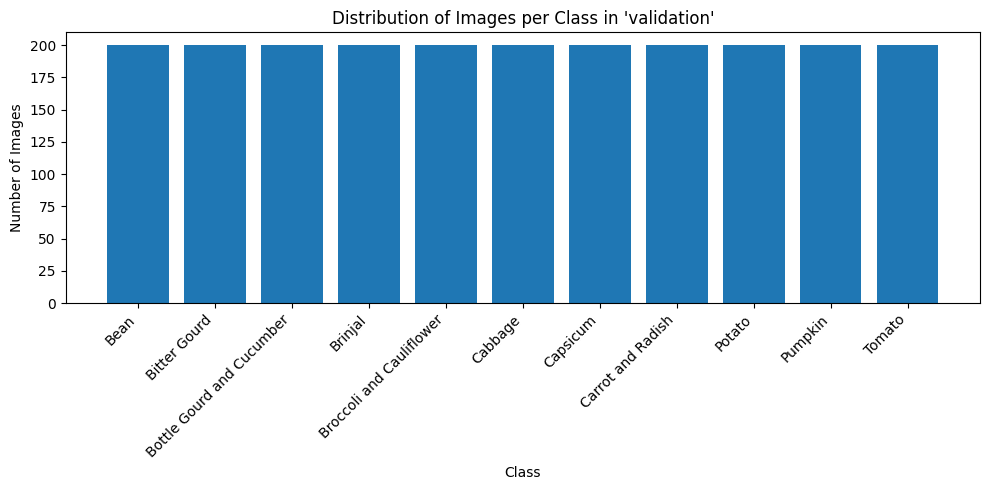

Counts for each label in dataset :
  Bean : 200
  Bitter Gourd : 200
  Bottle Gourd and Cucumber : 200
  Brinjal : 200
  Broccoli and Cauliflower : 200
  Cabbage : 200
  Capsicum : 200
  Carrot and Radish : 200
  Potato : 200
  Pumpkin : 200
  Tomato : 200


In [5]:
# plotting the label counts for validation data 
plot_label_counts(val_dir)
# same number of counts for each label, model will be validated fairly as validation data is fair

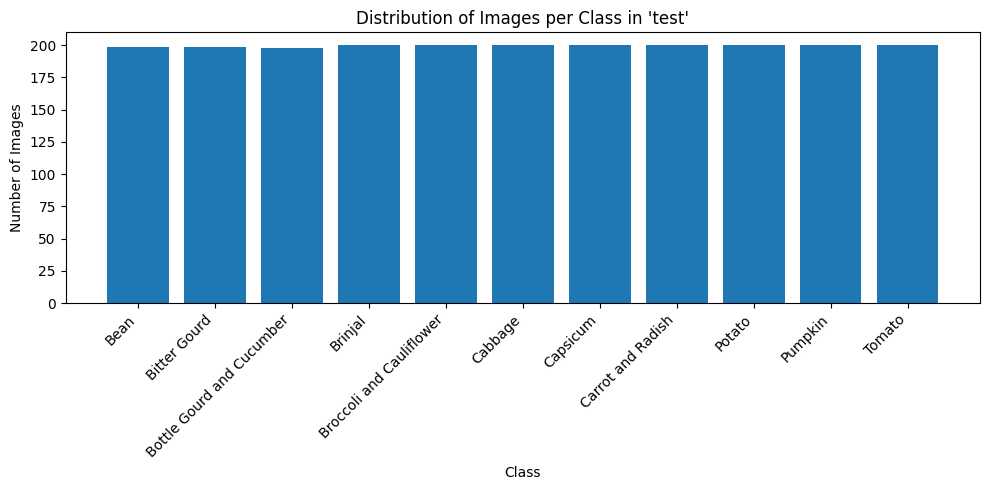

Counts for each label in dataset :
  Bean : 199
  Bitter Gourd : 199
  Bottle Gourd and Cucumber : 198
  Brinjal : 200
  Broccoli and Cauliflower : 200
  Cabbage : 200
  Capsicum : 200
  Carrot and Radish : 200
  Potato : 200
  Pumpkin : 200
  Tomato : 200


In [6]:
# plotting the label counts for test data 
plot_label_counts(test_dir)
# same number of counts for each label, model will be tested fairly as test data is fair

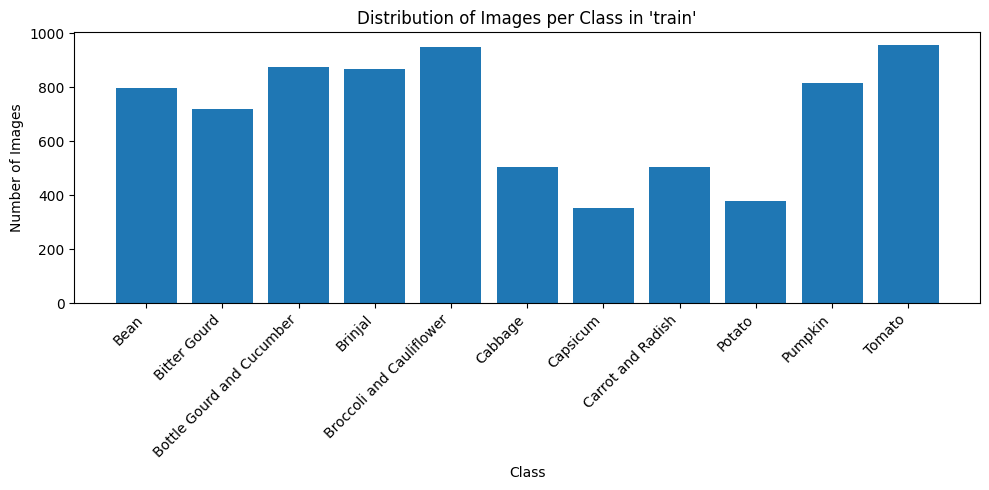

Counts for each label in dataset :
  Bean : 795
  Bitter Gourd : 720
  Bottle Gourd and Cucumber : 875
  Brinjal : 868
  Broccoli and Cauliflower : 948
  Cabbage : 503
  Capsicum : 351
  Carrot and Radish : 504
  Potato : 377
  Pumpkin : 814
  Tomato : 955


In [7]:
# plotting the label counts for train data 
plot_label_counts(train_dir)
# some imbalance eg more data for 'Broccoli and Cauliflower' and 'Tomato'
# model may be better trained to predict labels with more data 
# and may be not as good when predicting labels with less training data

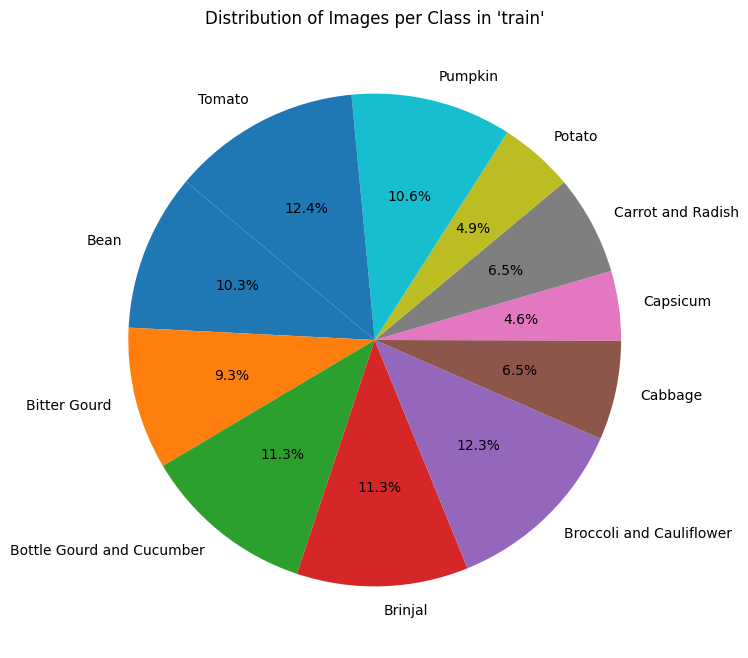

In [8]:
# we plot a pie chart visualization to further support the fact that there is biased data

# data extracted from the bar chart above
data = {
    'Class': [
        'Bean', 'Bitter Gourd', 'Bottle Gourd and Cucumber', 'Brinjal',
        'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish',
        'Potato', 'Pumpkin', 'Tomato'
    ],
    'Number of Images': [
        795, 720, 875, 868, 948, 503, 351, 504, 377, 814, 955
    ]
}

# creating dataFrame
df = pd.DataFrame(data)

# plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(df['Number of Images'], labels=df['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Class in \'train\'')
plt.show()

# we can see that there really is a bias in data, hence we will carry out data augmentation

#

# **Dealing with biased data (in train data)**
###### - It can be seen that the train data is biased. 
###### - The classes have varying number of data. 
###### - May lead to biased (better trained to predict labels with more data and predict labels with less data more poorly).
###### - To solve this, we carry out focused data augmentation.
###### - This will artificially increase the amount of training data by applying various transformations to the existing images.
###### - We will also carry out data augmentation on the other classes (even those with more data in their class) to provide more data for training as well.

### --> This will be done after importing the data, directly to the train datasets for the 23 x 23 model and the 101 x 101 model.

#

# **Importing data for 23x23 model**
###### - Data needs to be in the form of 23 x 23 pixels. 
###### - Data is imported from the directory for train, test and validation respectively.
###### - The batch_size is set to 23 to ensure all data is set to 23 x 23 pixels. 
###### - The label_mode is set to 'categorical' so as to ensure that the data is labelled / categorized. 
###### - An example of the data imported will be shown.

In [9]:
# loading the data for the 23x23 model

# batch size, can be adjusted
batch_size_23 = 32  

# train dataset, grayscaled, for 23x23
train_ds_23 = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(23, 23), # setting image pixels : 23 x 23
    batch_size=batch_size_23,
    shuffle=True,
    color_mode='grayscale'
)

# validation dataset, grayscaled, for 23x23
val_ds_23 = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(23, 23), # setting image pixels : 23 x 23
    batch_size=batch_size_23,
    shuffle=False,
    color_mode='grayscale'
)

# test dataset, grayscaled, for 23x23
test_ds_23 = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(23, 23), # setting image pixels : 23 x 23
    batch_size=batch_size_23,
    shuffle=False,
    color_mode='grayscale'
)

# get the class names of the dataset
# since all the class_names are the same, we can get it from any folder 
# since it is the same throughout, only need to define class names once in this project
class_names = train_ds_23.class_names # (only need to do this once since 101x101 model uses the exact sae dataset and classes)

# show the classes
print('\nClasses : ', class_names)  

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2196 files belonging to 11 classes.

Classes :  ['Bean', 'Bitter Gourd', 'Bottle Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']


#

### **Visualising loaded data for 23x23 model**
###### - This is to ensure that the data is correctly loaded with labels and in the correct dimensions (23 x 23 pixels)

In [10]:
# defining a function to display 5 random data 

def show_examples(dataset, class_names, num_examples=5):

    plt.figure(figsize=(16, 16)) # setting figsize

    examples_shown = 0 # counting number of examples shown

    chosen_classes = random.sample(class_names, num_examples)  # randomly select classes
    
    class_indices = [class_names.index(class_name) for class_name in chosen_classes] # gets indices of chosen classes

    for images, labels in dataset:
        for i in range(images.shape[0]):
            label_index = tf.argmax(labels[i]).numpy()

            if label_index in class_indices:
                ax = plt.subplot(1, num_examples, examples_shown + 1)
                img = tf.squeeze(images[i]).numpy().astype("uint8")
                plt.imshow(img, cmap='gray')
                plt.title(class_names[label_index])
                plt.axis("off")

                class_indices.remove(label_index) # remove the index so we dont show another example from this class

                examples_shown += 1 # increase examples shown counter

            # if examples shown is already past 5, show plot and return
            if examples_shown >= num_examples:
                plt.show()
                return

Training set examples:


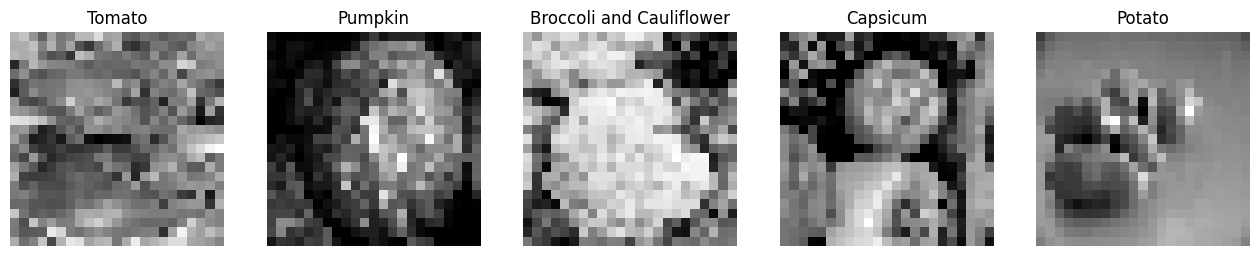


Validation set examples:


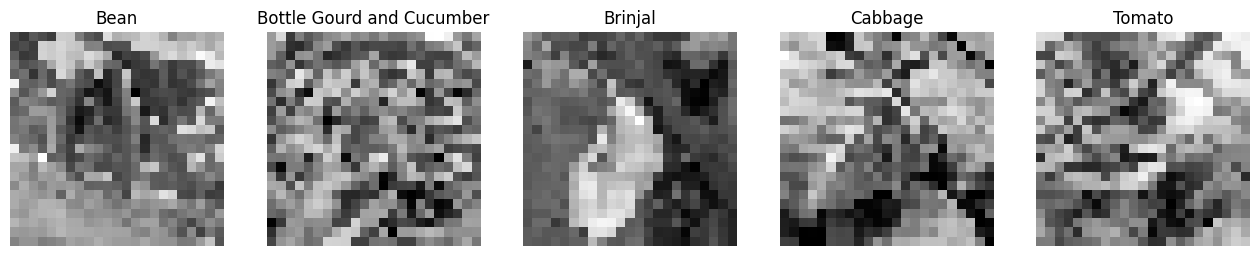


Test set examples:


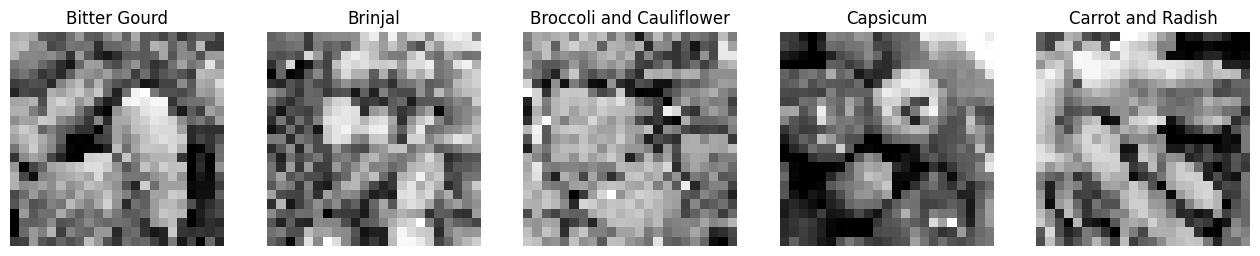

In [11]:
# verify that data is correctly imported with the respective labels, and is in 32x32 pixels

# Show examples from the training set
print("Training set examples:")
show_examples(train_ds_23, class_names, num_examples=5)

# Show examples from the validation set
print("\nValidation set examples:")
show_examples(val_ds_23, class_names, num_examples=5)

# Show examples from the test set
print("\nTest set examples:")
show_examples(test_ds_23, class_names, num_examples=5)

#

# **Augmenting train data for 23x23 model**
###### - As mentioned infront, this is to make the train data balanced. 
###### - This gets rid of bias, and will train the model better. 
###### - We apply this directly to the imported train_ds_23.
###### - We make all classes have 955 data, because the class with the most data has 955 data, so we make all classes match it.

In [12]:
# desired number of samples per class (make all uniform to 1000)
target_count_per_class = 955

print("Starting data augmentation and balancing for all classes in train_ds_23.")

# unbatch the training dataset to process individual images
unbatched_train_ds_23 = train_ds_23.unbatch()

# define the augmentation pipeline using keras preprocessing layers
def augment_image(image, label):

    image = tf.cast(image, tf.float32)

    # augmentation parameters:
    augmentation_pipeline = tf.keras.Sequential([

        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(factor=0.007, fill_mode='nearest'),
        layers.RandomZoom(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025), fill_mode='nearest'),
        layers.RandomTranslation(height_factor=0.025, width_factor=0.025, fill_mode='nearest'),
        layers.RandomBrightness(factor=0.05),
        layers.RandomContrast(factor=0.05),
    ], name="augmentation")

    # apply the augmentations
    augmented_image = augmentation_pipeline(image)

    # clip values to ensure they stay within [0, 1] after augmentation
    augmented_image = tf.clip_by_value(augmented_image, 0.0, 1.0)

    return augmented_image, label

# get current class counts
print("Calculating current class counts in train_ds_23...")
current_class_counts_23 = {idx: 0 for idx in range(len(class_names))}

# iterate through the unbatched dataset to get counts
for _, label in unbatched_train_ds_23:
    class_idx = tf.argmax(label).numpy()
    current_class_counts_23[class_idx] += 1

print("Current class counts:", current_class_counts_23)


# process each class: augment if needed, and combine into a list of datasets
balanced_datasets_list = []

for idx, class_name in enumerate(class_names):
    current_count = current_class_counts_23[idx]

    # filter the unbatched dataset to get samples for the current class
    single_class_ds = unbatched_train_ds_23.filter(lambda img, lbl: tf.argmax(lbl) == idx)

    if current_count >= target_count_per_class:

        # if current count is sufficient, just add the original samples for this class
        balanced_datasets_list.append(single_class_ds)
        print(f"{class_name}: {current_count} images (no augmentation needed)")

    else:

        # Calculate how many times each original image needs to be augmented/repeated
        # to reach the target.
        num_new_samples_needed = target_count_per_class - current_count
        repeat_factor = num_new_samples_needed // current_count
        remaining_needed = num_new_samples_needed % current_count

        print(f"{class_name}: {current_count} → {target_count_per_class} (repeating each {repeat_factor}x + {remaining_needed} more)")

        # create augmented copies by repeating and mapping the augmentation function
        augmented_copies_ds = single_class_ds.repeat(repeat_factor + 1).map(
            augment_image, num_parallel_calls=tf.data.AUTOTUNE
        ).take(num_new_samples_needed) # use .take() to ensure we get exactly the number of *new* augmented samples needed

        # concatenate original samples with the newly generated augmented samples for this class
        combined_class_ds = single_class_ds.concatenate(augmented_copies_ds)
        balanced_datasets_list.append(combined_class_ds)

print("Augmentation and balancing complete for all classes.")

# concatenate all balanced class datasets into the final training dataset
final_train_ds_23 = balanced_datasets_list[0]
for ds in balanced_datasets_list[1:]:
    final_train_ds_23 = final_train_ds_23.concatenate(ds)

# apply final shuffling and re-batching to the combined dataset
train_ds_23 = final_train_ds_23.shuffle(10000).batch(batch_size_23).prefetch(tf.data.AUTOTUNE)

Starting data augmentation and balancing for all classes in train_ds_23.
Calculating current class counts in train_ds_23...
Current class counts: {0: 795, 1: 720, 2: 875, 3: 868, 4: 948, 5: 503, 6: 351, 7: 504, 8: 377, 9: 814, 10: 955}
Bean: 795 → 955 (repeating each 0x + 160 more)
Bitter Gourd: 720 → 955 (repeating each 0x + 235 more)
Bottle Gourd and Cucumber: 875 → 955 (repeating each 0x + 80 more)
Brinjal: 868 → 955 (repeating each 0x + 87 more)
Broccoli and Cauliflower: 948 → 955 (repeating each 0x + 7 more)
Cabbage: 503 → 955 (repeating each 0x + 452 more)
Capsicum: 351 → 955 (repeating each 1x + 253 more)
Carrot and Radish: 504 → 955 (repeating each 0x + 451 more)
Potato: 377 → 955 (repeating each 1x + 201 more)
Pumpkin: 814 → 955 (repeating each 0x + 141 more)
Tomato: 955 images (no augmentation needed)
Augmentation and balancing complete for all classes.


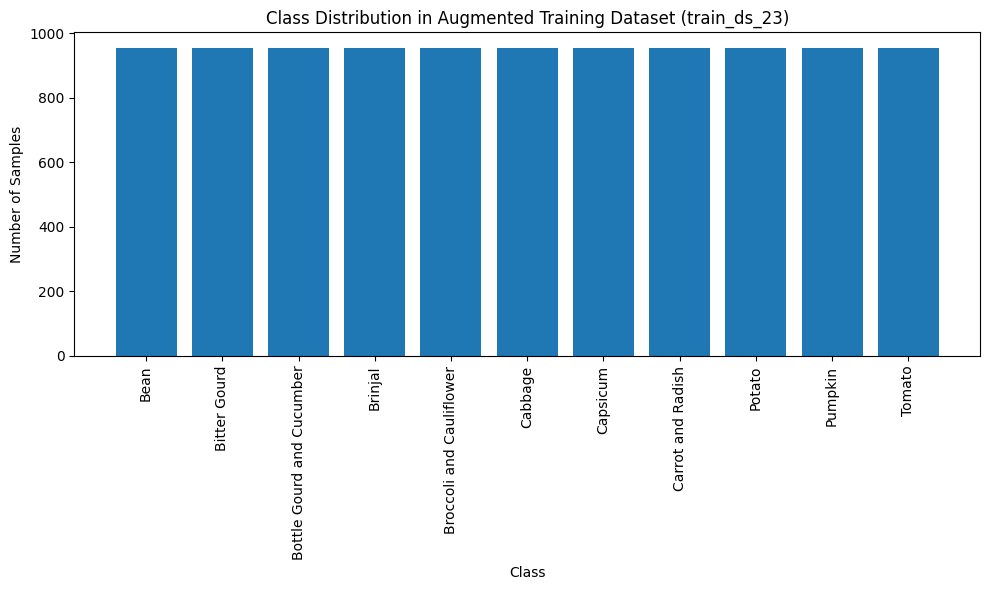


Number of samples in each class for train_ds_23 :
Bean: 955
Bitter Gourd: 955
Bottle Gourd and Cucumber: 955
Brinjal: 955
Broccoli and Cauliflower: 955
Cabbage: 955
Capsicum: 955
Carrot and Radish: 955
Potato: 955
Pumpkin: 955
Tomato: 955


In [13]:
# now we plot a bar chart again to see if the dataset is more balanced and the minority classes have had their data increased successfully

# initialize counts
class_counts_23 = np.zeros(11, dtype=int)

# count samples per class
for image, label in train_ds_23.unbatch():
    class_index_23 = tf.argmax(label).numpy()
    class_counts_23[class_index_23] += 1

# plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts_23)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Augmented Training Dataset (train_ds_23)')
plt.tight_layout()
plt.show()

# print number of data in each class
print("\nNumber of samples in each class for train_ds_23 :")
for class_name, count in zip(class_names, class_counts_23):
    print(f"{class_name}: {count}")

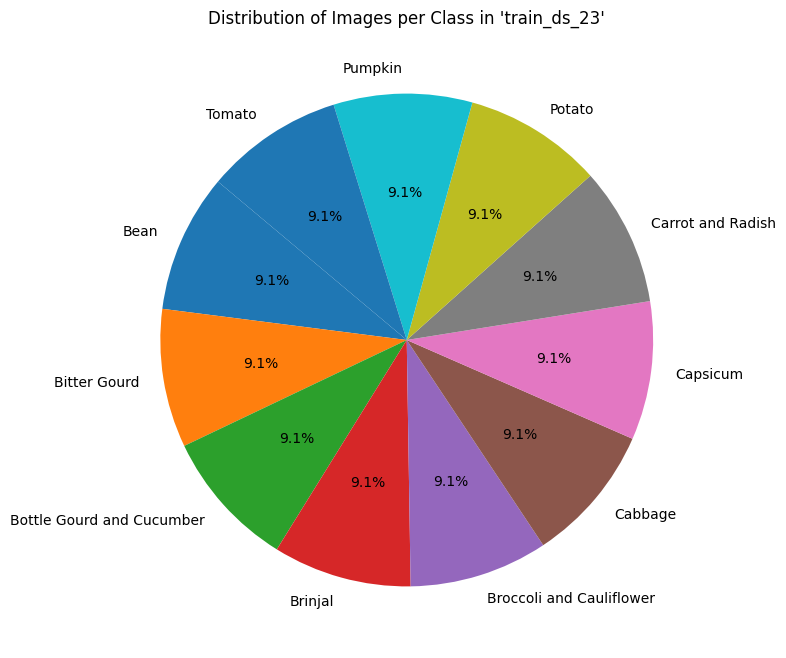

In [14]:
# we plot a pie chart visualization to further check that data is successfully augmented

# data extracted from the bar chart above
data_augmented_23 = {
    'Class': [
        'Bean', 'Bitter Gourd', 'Bottle Gourd and Cucumber', 'Brinjal',
        'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish',
        'Potato', 'Pumpkin', 'Tomato'
    ],
    'Number of Images': [
        955, 955, 955, 955, 955, 955, 955, 955, 955, 955, 955
    ]
}

# creating dataFrame
df_augmented_23 = pd.DataFrame(data_augmented_23)

# plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(df_augmented_23['Number of Images'], labels=df_augmented_23['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Class in \'train_ds_23\'')
plt.show()

# we can see that after augmentation, data is less biased, now we can move on

###### - We can see that after augmenting the data, the data is exactly balanced now, with all classes having the same number of data. 
###### - Now train_ds_23 can be used to train our models.

#

#

# **Importing data for 101x101 model**
###### - Data needs to be in the form of 101 x 101 pixels. 
###### - Data is imported from the directory for train, test and validation respectively.
###### - The batch_size is set to 101 to ensure all data is set to 101 x 101 pixels. 
###### - The label_mode is set to 'categorical' so as to ensure that the data is labelled / categorized. 
###### - An example of the data imported will be shown.

In [15]:
# loading the data for the 101x101 model

# batch size, can be adjusted
batch_size_101 = 32

# train dataset, grayscaled, for 101x101
train_ds_101 = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(101, 101), # setting image pixels : 101 x 101
    batch_size=batch_size_101,
    shuffle=True,
    color_mode='grayscale'
)

# validation dataset, grayscaled, for 101x101
val_ds_101 = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(101, 101), # setting image pixels : 101 x 101
    batch_size=batch_size_101,
    shuffle=False,
    color_mode='grayscale'
)

# test dataset, grayscaled, for 101x101
test_ds_101 = image_dataset_from_directory(
    test_dir,    
    labels='inferred',
    label_mode='categorical',
    image_size=(101, 101), # setting image pixels : 101 x 101
    batch_size=batch_size_101,
    shuffle=False,
    color_mode='grayscale'
)

# show the classes
print('\nClasses : ', class_names)  

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2196 files belonging to 11 classes.

Classes :  ['Bean', 'Bitter Gourd', 'Bottle Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']


#

### **Visualising loaded data for 101x101 model**
###### - This is to ensure that the data is correctly loaded with labels and in the correct dimensions (101 x 101 pixels)

Training set examples:


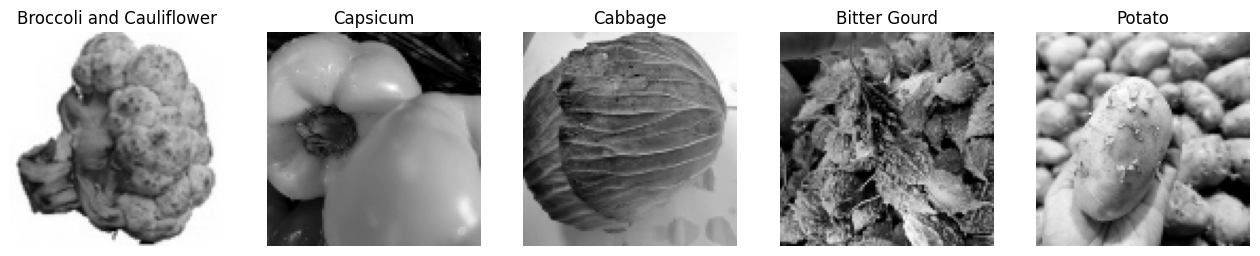


Validation set examples:


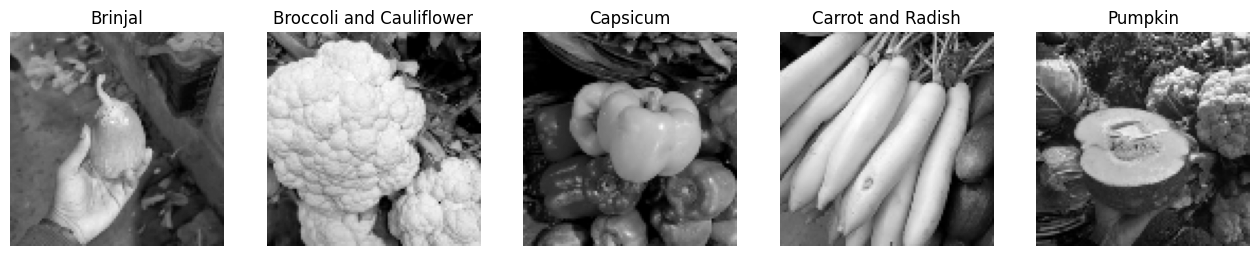


Test set examples:


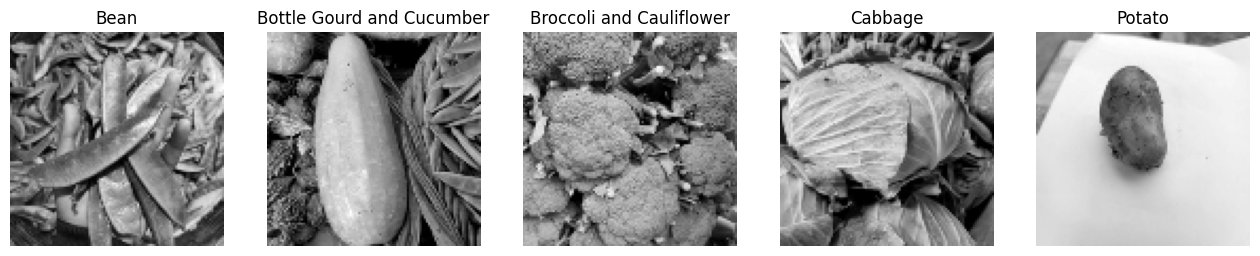

In [16]:
# verify that data is correctly imported with the respective labels, and is in 32x32 pixels 
# data is shown using a previously defined function for 23x23 model

# Show examples from the training set
print("Training set examples:")
show_examples(train_ds_101, class_names, num_examples=5)

# Show examples from the validation set
print("\nValidation set examples:")
show_examples(val_ds_101, class_names, num_examples=5)

# Show examples from the test set
print("\nTest set examples:")
show_examples(test_ds_101, class_names, num_examples=5)

#

# **Augmenting train data for 101x101 model**
###### - As mentioned infront, this is to make the train data balanced. 
###### - This gets rid of bias, and will train the model better. 
###### - We apply this directly to the imported train_ds_101.
###### - This is the exact same process as that done above for train_ds_23.
###### - We make all classes have 955 data, because the class with the most data has 955 data, so we make all classes match it. Similar as before.

In [17]:
# desired number of samples per class (make all uniform to 1000)
target_count_per_class = 955

print("Starting data augmentation and balancing for all classes in train_ds_101.")

# unbatch the training dataset to process individual images
unbatched_train_ds_101 = train_ds_101.unbatch()

# define the augmentation pipeline using keras preprocessing layers
def augment_image(image, label):

    image = tf.cast(image, tf.float32)

    # augmentation parameters
    augmentation_pipeline = tf.keras.Sequential([

        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(factor=0.007, fill_mode='nearest'),
        layers.RandomZoom(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025), fill_mode='nearest'),
        layers.RandomTranslation(height_factor=0.025, width_factor=0.025, fill_mode='nearest'),
        layers.RandomBrightness(factor=0.05),
        layers.RandomContrast(factor=0.05),
    ], name="augmentation")

    # apply the augmentations
    augmented_image = augmentation_pipeline(image)

    # clip values to ensure they stay within [0, 1] after augmentation
    augmented_image = tf.clip_by_value(augmented_image, 0.0, 1.0)

    return augmented_image, label

# get current class counts
print("Calculating current class counts in train_ds_101...")
current_class_counts_101 = {idx: 0 for idx in range(len(class_names))}

# iterate through the unbatched dataset to get counts
for _, label in unbatched_train_ds_101:
    class_idx = tf.argmax(label).numpy()
    current_class_counts_101[class_idx] += 1

print("Current class counts:", current_class_counts_101)


# process each class: augment if needed, and combine into a list of datasets
balanced_datasets_list = []

for idx, class_name in enumerate(class_names):
    current_count = current_class_counts_101[idx]

    # filter the unbatched dataset to get samples for the current class
    single_class_ds = unbatched_train_ds_101.filter(lambda img, lbl: tf.argmax(lbl) == idx)

    if current_count >= target_count_per_class:

        # if current count is sufficient, just add the original samples for this class
        balanced_datasets_list.append(single_class_ds)
        print(f"{class_name}: {current_count} images (no augmentation needed)")

    else:

        # calculate how many times each original image needs to be augmented/repeated
        # to reach the target.
        num_new_samples_needed = target_count_per_class - current_count
        repeat_factor = num_new_samples_needed // current_count
        remaining_needed = num_new_samples_needed % current_count

        print(f"{class_name}: {current_count} → {target_count_per_class} (repeating each {repeat_factor}x + {remaining_needed} more)")

        # create augmented copies by repeating and mapping the augmentation function
        augmented_copies_ds = single_class_ds.repeat(repeat_factor + 1).map(
            augment_image, num_parallel_calls=tf.data.AUTOTUNE
        ).take(num_new_samples_needed) # use .take() to ensure we get exactly the number of *new* augmented samples needed

        # concatenate original samples with the newly generated augmented samples for this class
        combined_class_ds = single_class_ds.concatenate(augmented_copies_ds)
        balanced_datasets_list.append(combined_class_ds)

print("Augmentation and balancing complete for all classes.")

# concatenate all balanced class datasets into the final training dataset
final_train_ds_101 = balanced_datasets_list[0]
for ds in balanced_datasets_list[1:]:
    final_train_ds_101 = final_train_ds_101.concatenate(ds)

# apply final shuffling and re-batching to the combined dataset
train_ds_101 = final_train_ds_101.shuffle(10000).batch(batch_size_101).prefetch(tf.data.AUTOTUNE)

Starting data augmentation and balancing for all classes in train_ds_101.
Calculating current class counts in train_ds_101...
Current class counts: {0: 795, 1: 720, 2: 875, 3: 868, 4: 948, 5: 503, 6: 351, 7: 504, 8: 377, 9: 814, 10: 955}
Bean: 795 → 955 (repeating each 0x + 160 more)
Bitter Gourd: 720 → 955 (repeating each 0x + 235 more)
Bottle Gourd and Cucumber: 875 → 955 (repeating each 0x + 80 more)
Brinjal: 868 → 955 (repeating each 0x + 87 more)
Broccoli and Cauliflower: 948 → 955 (repeating each 0x + 7 more)
Cabbage: 503 → 955 (repeating each 0x + 452 more)
Capsicum: 351 → 955 (repeating each 1x + 253 more)
Carrot and Radish: 504 → 955 (repeating each 0x + 451 more)
Potato: 377 → 955 (repeating each 1x + 201 more)
Pumpkin: 814 → 955 (repeating each 0x + 141 more)
Tomato: 955 images (no augmentation needed)
Augmentation and balancing complete for all classes.


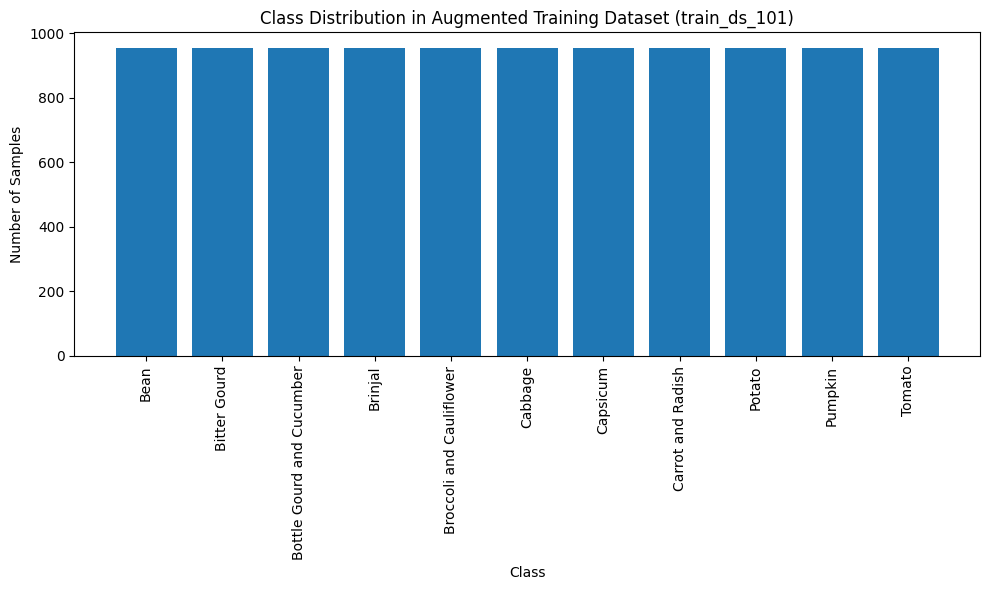


Number of samples in each class for train_ds_101 :
Bean: 955
Bitter Gourd: 955
Bottle Gourd and Cucumber: 955
Brinjal: 955
Broccoli and Cauliflower: 955
Cabbage: 955
Capsicum: 955
Carrot and Radish: 955
Potato: 955
Pumpkin: 955
Tomato: 955


In [18]:
# now we plot a bar chart again to see if the dataset is more balanced and the minority classes have had their data increased successfully

# initialize counts
class_counts_101 = np.zeros(11, dtype=int)

# count samples per class
for image, label in train_ds_101.unbatch():
    class_index_101 = tf.argmax(label).numpy()
    class_counts_101[class_index_101] += 1

# plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts_101)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Augmented Training Dataset (train_ds_101)')
plt.tight_layout()
plt.show()

# print number of data in each class
print("\nNumber of samples in each class for train_ds_101 :")
for class_name, count in zip(class_names, class_counts_101):
    print(f"{class_name}: {count}")

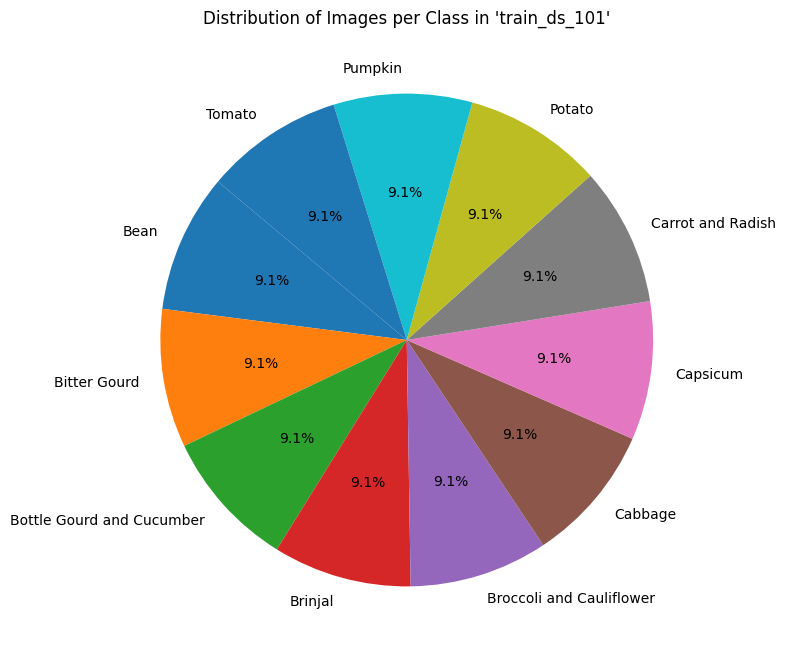

In [19]:
# we plot a pie chart visualization to further check that data is successfully augmented

# data extracted from the bar chart above
data_augmented_101 = {
    'Class': [
        'Bean', 'Bitter Gourd', 'Bottle Gourd and Cucumber', 'Brinjal',
        'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish',
        'Potato', 'Pumpkin', 'Tomato'
    ],
    'Number of Images': [
        955, 955, 955, 955, 955, 955, 955, 955, 955, 955, 955
    ]
}

# creating dataFrame
df_augmented_101 = pd.DataFrame(data_augmented_101)

# plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(df_augmented_101['Number of Images'], labels=df_augmented_101['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Class in \'train_ds_101\'')
plt.show()

# we can see that after augmentation, data is less biased, now we can move on

###### - We can see that after augmenting the data, the data is exactly balanced now, with all classes having the same number of data. 
###### - Now train_ds_101 can be used to train our models.

#

# **Training 23x23 model**
###### - Training a base model. 
###### - This base model for 23 x 23 pixels has been experimented to perform averagely. 
###### - This is just a base, and will be improved after by hyperparameter tuning, or other model improvements.
###### - Setting up base model (conv blocks and layers). 
###### - Evaluating on test data. 

#

### **Base 23x23 model**
###### - This is the end product after repeated experimenting to get a decent performing model. 
###### - The parameters inside this model will not be hyperparameter tuned again as it is manually tuned

In [20]:
# setting up the model and its layers

# loading the sequential model
model_23 = Sequential()


# first conv block

# 2d conv layer, 64 filters, 5x5 kernel, relu activation, same padding, l2 regularization 0.0001, input shape 23x23x1
model_23.add(Conv2D(64, (5, 5), activation = 'relu', padding='same', kernel_regularizer=l2(0.0001), input_shape=(23, 23, 1)))   

# batch normalization
model_23.add(BatchNormalization()) 

# max pooling, 2x2 pool size
model_23.add(MaxPooling2D(pool_size=(2, 2))) 

# dropout, 0.3 dropout rate
model_23.add(Dropout(0.3)) 



# second conv block

# 2d conv layer, 32 filters, 3x3 kernel, relu activation, same padding
model_23.add(Conv2D(32, (3, 3), activation = 'relu', padding='same')) 

# batch normalization
model_23.add(BatchNormalization()) 

# max pooling, 2x2 pool size
model_23.add(MaxPooling2D(pool_size=(2, 2))) 

# dropout, 0.3 dropout rate
model_23.add(Dropout(0.3)) 



# third conv block

# 2d conv layer, 64 filters, 3x3 kernel, relu activation, same padding
model_23.add(Conv2D(64, (3, 3), activation = 'relu', padding='same')) 

# batch normalization
model_23.add(BatchNormalization()) 



# flatten before dense layers

model_23.add(Flatten()) 



# fully connected layer

# dense layer, 128 units, relu activation
model_23.add(Dense(128, activation='relu')) 

# batch normalization
model_23.add(BatchNormalization()) 

# dropout, 0.3 dropout rate
model_23.add(Dropout(0.3))   



# output layer

# dense layer, 11 units (number of classes), softmax activation
model_23.add(Dense(11, activation='softmax')) 



# compiling the model

model_23.compile(optimizer=Adam(learning_rate=0.001), # adam optimizer, learning rate 0.001
                 loss='categorical_crossentropy', # categorical crossentropy loss
                 metrics=['accuracy', 'Precision']) 

In [21]:
# fitting the model with early stopping and reduce lr on plateau 
# using train and validation data

# early stopping to stop the model before it overfits
early_stopping_23 = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# reduce_lr automatically decreases the learning rate during training when val_lose stops improving
# helps the optimizer to escape plateaus and fine-tune weights for better convergence
reduce_lr_23 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# fitting the model using 100 epochs and 100 batch_size
history_23 = model_23.fit(train_ds_23, epochs=100, validation_data=val_ds_23, verbose = 1, callbacks = [early_stopping_23, reduce_lr_23], batch_size = 64)

Epoch 1/100
329/329 [==============================] - 42s 21ms/step - loss: 2.2183 - accuracy: 0.2652 - precision: 0.4014 - val_loss: 1.6977 - val_accuracy: 0.4641 - val_precision: 0.7011 - lr: 0.0010
Epoch 2/100
329/329 [==============================] - 25s 10ms/step - loss: 1.7850 - accuracy: 0.3867 - precision: 0.6164 - val_loss: 1.4427 - val_accuracy: 0.5232 - val_precision: 0.7253 - lr: 0.0010
Epoch 3/100
329/329 [==============================] - 25s 11ms/step - loss: 1.5592 - accuracy: 0.4581 - precision: 0.7219 - val_loss: 1.5898 - val_accuracy: 0.4941 - val_precision: 0.6208 - lr: 0.0010
Epoch 4/100
329/329 [==============================] - 25s 11ms/step - loss: 1.4035 - accuracy: 0.5083 - precision: 0.7613 - val_loss: 1.0364 - val_accuracy: 0.6600 - val_precision: 0.7639 - lr: 0.0010
Epoch 5/100
329/329 [==============================] - 26s 10ms/step - loss: 1.3126 - accuracy: 0.5413 - precision: 0.7950 - val_loss: 2.0856 - val_accuracy: 0.3923 - val_precision: 0.4839 - l

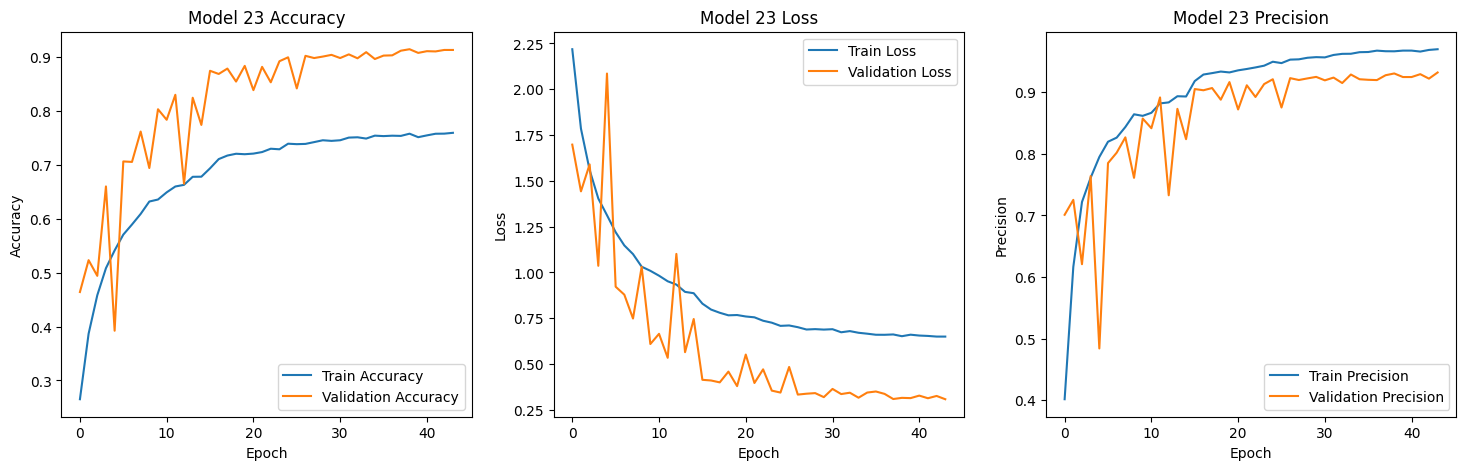

In [22]:
# to check for overfitting using accuracy

plt.figure(figsize=(18, 5))

# plot training & validation accuracy values over epoch

plt.subplot(1, 3, 1)
plt.plot(history_23.history['accuracy'], label='Train Accuracy')
plt.plot(history_23.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 23 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# to check for overfitting using loss

# plot training & validation loss values over epoch
plt.subplot(1, 3, 2)
plt.plot(history_23.history['loss'], label='Train Loss')
plt.plot(history_23.history['val_loss'], label='Validation Loss')
plt.title('Model 23 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# plot training & validation loss values over epoch
plt.subplot(1, 3, 3)
plt.plot(history_23.history['precision'], label='Train Precision')
plt.plot(history_23.history['val_precision'], label='Validation Precision')
plt.title('Model 23 Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

#

# **Function for confusion matrix**
###### - We write a function that can be reused to display a confusion matrix.
###### - This can be reused throughout the project.

In [23]:
###############################################################
# function to get predictions and true labels for a given dataset --> used for plotting confusion matrix
###############################################################

def get_predictions_and_labels(model, dataset):

    # empty lists to store labels and predictions 
    all_labels = []
    all_predictions = []

    for images, labels in dataset:

        # making the model predict on test dataset's images
        predictions = model.predict(images)

        # convert one-hot labels to class indices
        true_labels = np.argmax(labels, axis=1)
        predicted_labels = np.argmax(predictions, axis=1)
        all_labels.extend(true_labels)
        all_predictions.extend(predicted_labels)

    return np.array(all_labels), np.array(all_predictions)

#

1/1 [==============================] - 0s 149ms/step
23 x 23 base model confusion matrix :




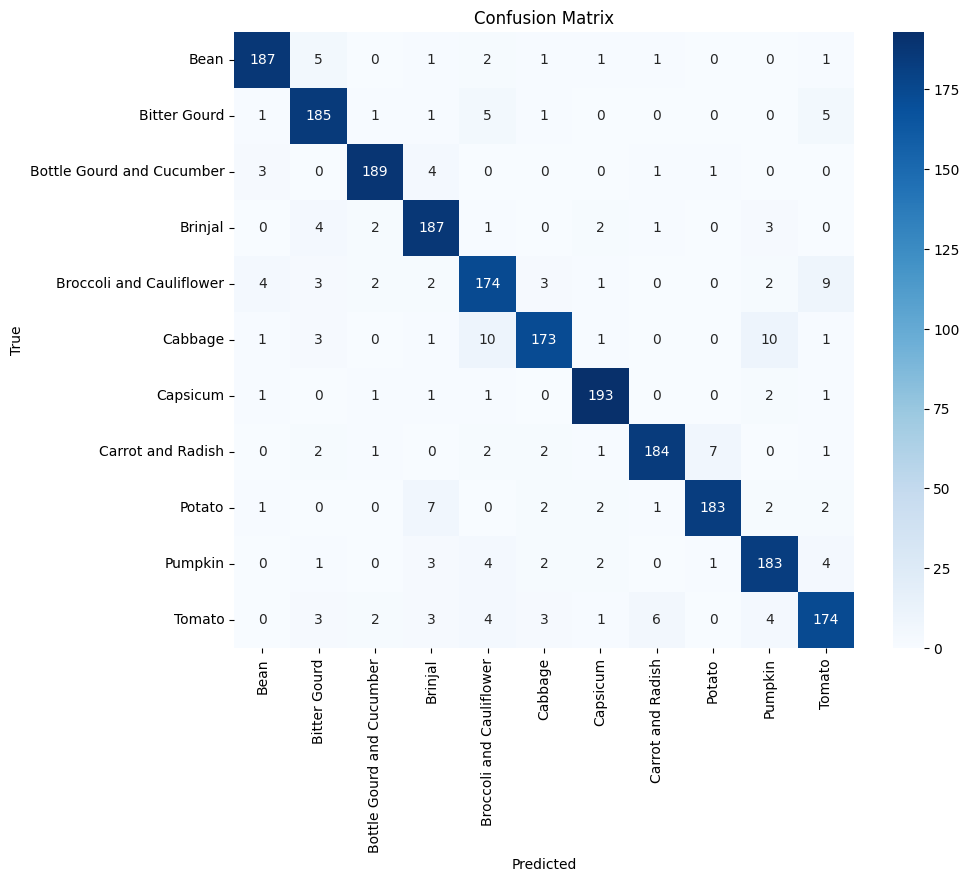

In [24]:
###############################################################
# confusion matrix to visualize 23 x 23 model's performance
###############################################################

# get predictions and true labels for the test set for 23 x 23 model
y_true_23_base, y_pred_23_base = get_predictions_and_labels(model_23, test_ds_23)  

# calculate the confusion matrix
cm_23 = confusion_matrix(y_true_23_base, y_pred_23_base)

print('23 x 23 base model confusion matrix :\n\n')

# display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_23, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# evaluating the model using test data
evaluation_results_base23 = model_23.evaluate(test_ds_23, verbose=1)

# printing the test results
print(f"\nTest Loss : {evaluation_results_base23[0]:.6f}")
print(f"Test Accuracy : {evaluation_results_base23[1] * 100:.3f}%")
print(f"Test Precision : {evaluation_results_base23[2] * 100:.3f}%")

69/69 [==============================] - 0s 6ms/step - loss: 0.2906 - accuracy: 0.9162 - precision: 0.9313

Test Loss : 0.290623
Test Accuracy : 91.621%
Test Precision : 93.133%


#

# **Hyperparameter tuning 23x23 model** 
###### - Hyperparameter tune the model now. 
###### - This is to get the best parameters for the model such that the model is trained the best and can achieve the best validation accuracy. 
###### - The best combination of parameters will be printed out and then used to evaluate the model on the train data.

In [26]:
# hyperparameter tuning the 23x23 model to get the best combination of hyperparameters to produce the best result

# define hyperparameter to experiment with
learning_rate_candidates_23 = [1e-3, 5e-3, 1e-4]
batch_size_candidates_23 = [32, 64, 128]  

# since the hyperparameters inside the base model have already been manually tuned to reduce overfitting, no need to tune again

# setting the first best hyperparameters and corresponding validation accuracy
best_val_accuracy_23 = 0.0
best_val_precision_23 = 0.0
best_val_loss_23 = float('inf')  # initialize with a very high value
best_learning_rate_23 = 0.0
best_batch_size_23 = 0.0  

# early stopping callback
early_stopping_23_tuning = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)  

LR: 0.001, Batch Size: 32, Validation Accuracy: 0.879545, Validation Loss: 0.403442, Validation Precision: 0.897351
1/1 [==============================] - 0s 150ms/step


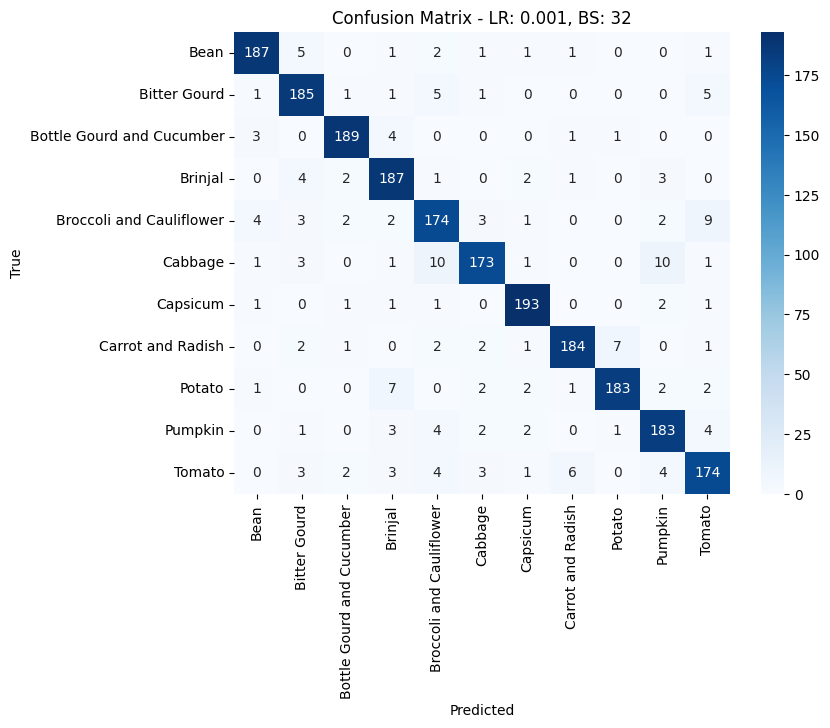

LR: 0.001, Batch Size: 64, Validation Accuracy: 0.832273, Validation Loss: 0.630715, Validation Precision: 0.857414
1/1 [==============================] - 0s 91ms/step


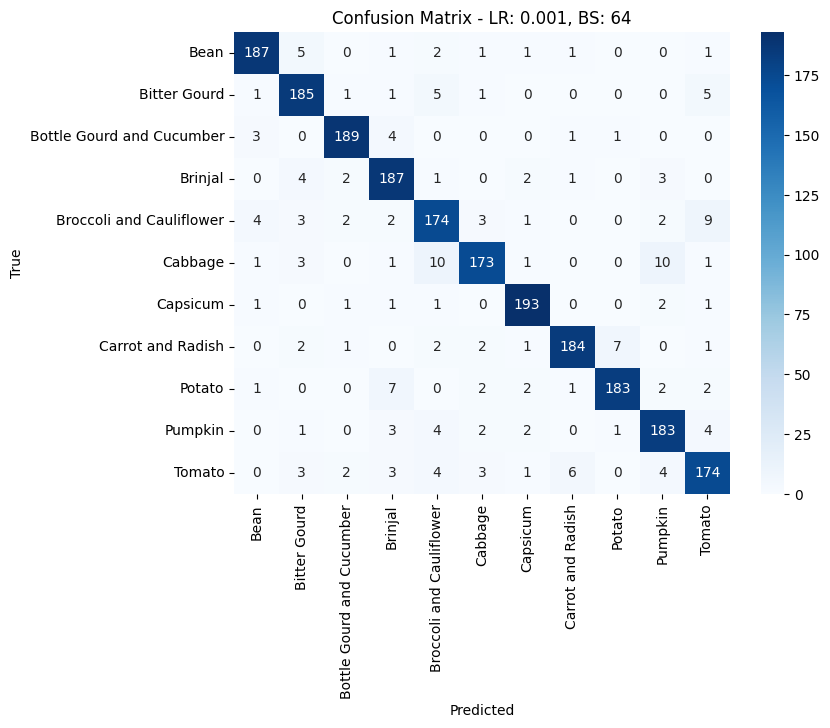

LR: 0.001, Batch Size: 128, Validation Accuracy: 0.777727, Validation Loss: 0.812871, Validation Precision: 0.806967
1/1 [==============================] - 0s 97ms/step


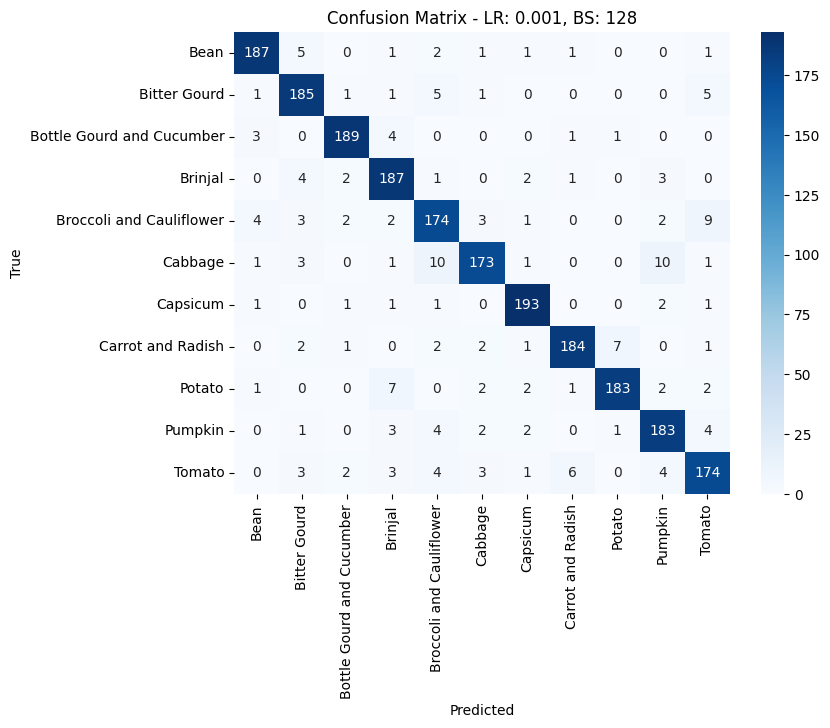

LR: 0.005, Batch Size: 32, Validation Accuracy: 0.832273, Validation Loss: 0.584536, Validation Precision: 0.861614
1/1 [==============================] - 0s 114ms/step


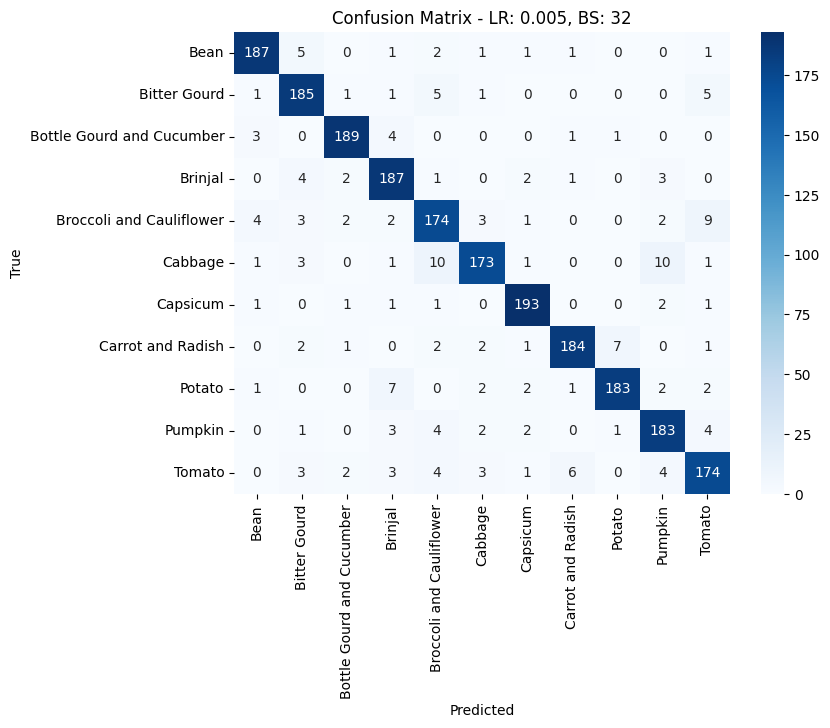

LR: 0.005, Batch Size: 64, Validation Accuracy: 0.870000, Validation Loss: 0.448349, Validation Precision: 0.902879
1/1 [==============================] - 0s 196ms/step


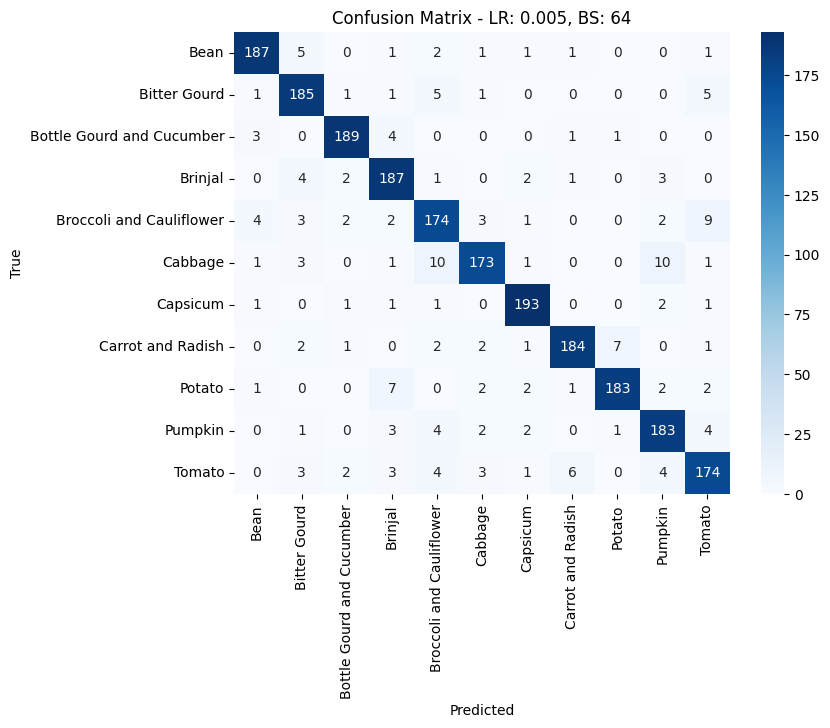

LR: 0.005, Batch Size: 128, Validation Accuracy: 0.783182, Validation Loss: 0.772843, Validation Precision: 0.815049
1/1 [==============================] - 0s 92ms/step


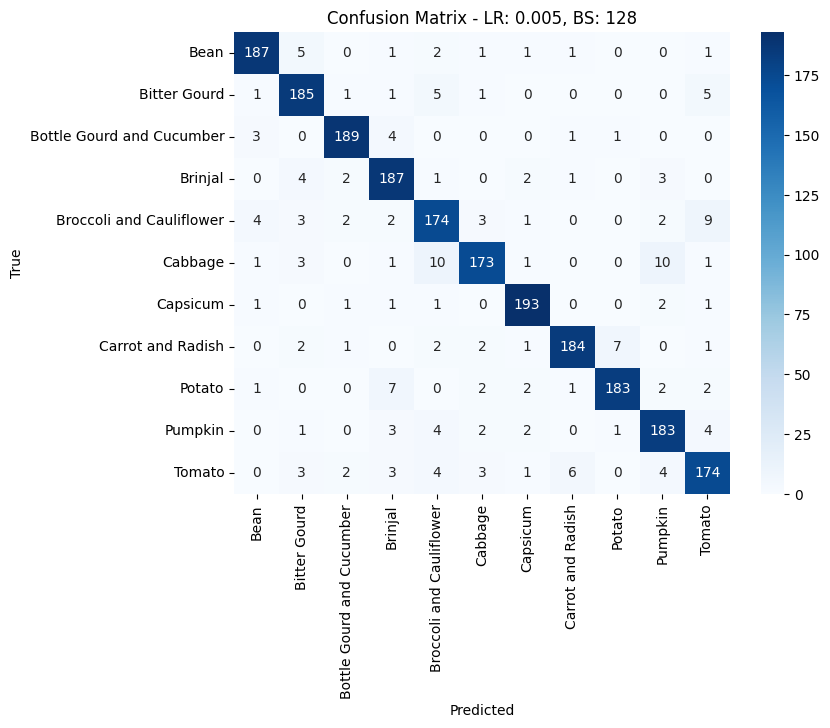

LR: 0.0001, Batch Size: 32, Validation Accuracy: 0.916818, Validation Loss: 0.319529, Validation Precision: 0.930601
1/1 [==============================] - 0s 122ms/step


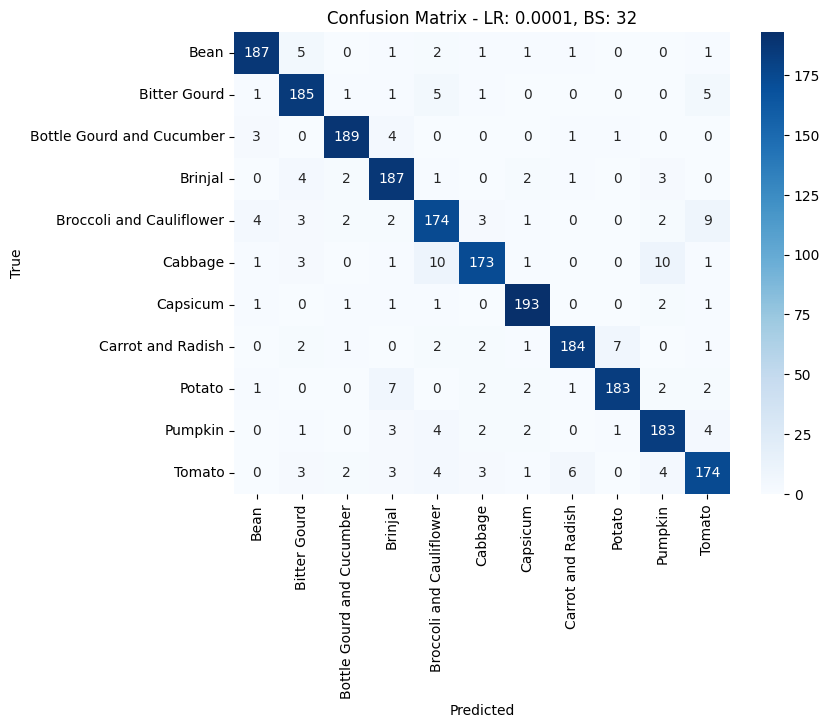

LR: 0.0001, Batch Size: 64, Validation Accuracy: 0.919091, Validation Loss: 0.309893, Validation Precision: 0.932898
1/1 [==============================] - 0s 107ms/step


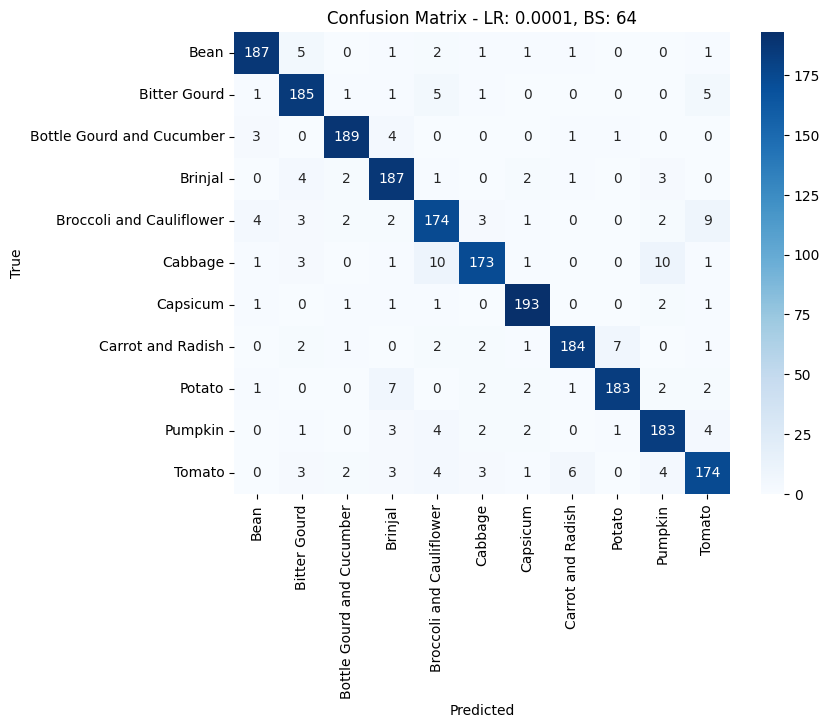

LR: 0.0001, Batch Size: 128, Validation Accuracy: 0.924091, Validation Loss: 0.303584, Validation Precision: 0.934229
1/1 [==============================] - 0s 161ms/step


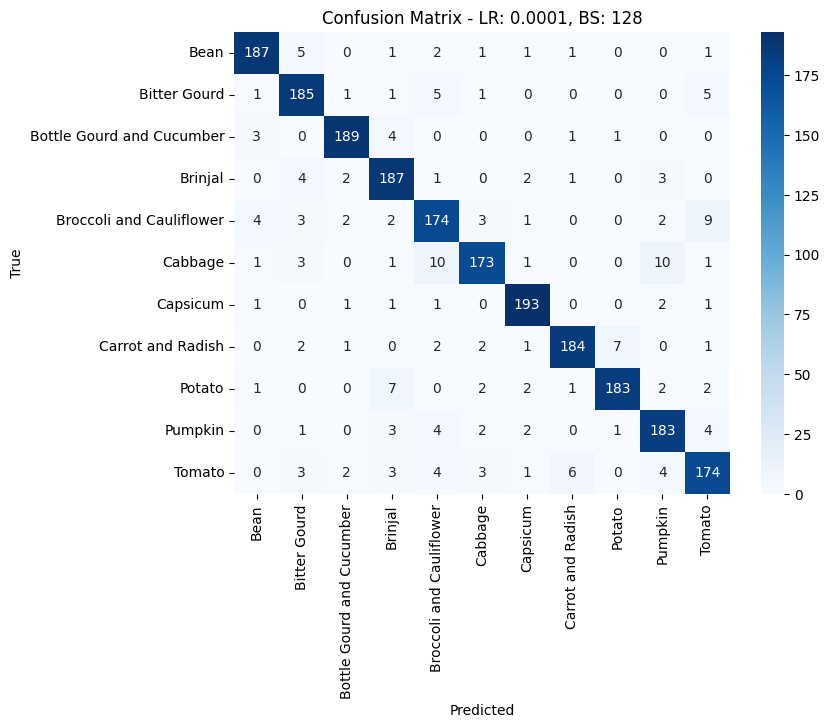


Best hyperparameters for 23 x 23 model :
Learning Rate: 0.0001
Batch Size: 128

Best Validation Accuracy: 0.924091
Best Validation Loss: 0.303584
Best Validation Precision: 0.934229


In [27]:
# now we iterate through hyperparameter combinations

for learning_rate in learning_rate_candidates_23:

    for batch_size in batch_size_candidates_23:

        # set optimizer to adam
        optimizer = Adam(learning_rate=learning_rate)

        # compile the model 
        model_23.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])

        # train the model
        history = model_23.fit(
            train_ds_23,
            epochs=100,  # 100 epochs used as there is early stopping
            validation_data=val_ds_23,
            verbose=0,
            callbacks=[early_stopping_23_tuning],
            batch_size=batch_size
        )

        # evaluate and store the best metrics
        val_loss = history.history['val_loss'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        val_precision = history.history['val_precision'][-1]

        # printing to monitor progress
        print(f"LR: {learning_rate}, Batch Size: {batch_size}, Validation Accuracy: {val_accuracy:.6f}, Validation Loss: {val_loss:.6f}, Validation Precision: {val_precision:.6f}")

        if val_loss < best_val_loss_23 and val_accuracy > best_val_accuracy_23 and val_precision > best_val_precision_23 :
            best_val_accuracy_23 = val_accuracy
            best_val_loss_23 = val_loss
            best_val_precision_23 = val_precision
            best_learning_rate_23 = learning_rate
            best_batch_size_23 = batch_size

        # get predictions and true labels for the test set
        y_true_23, y_pred_23 = get_predictions_and_labels(model_23, test_ds_23)

        # calculate the confusion matrix
        cm_23_tuning = confusion_matrix(y_true_23_base, y_pred_23_base)

        # display the confusion matrix for each hyperparameter combination
        plt.figure(figsize=(8, 6))  
        sns.heatmap(cm_23_tuning, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - LR: {learning_rate}, BS: {batch_size}')  # Include parameters in title
        plt.show()


# print the best hyperparameters after finding out which of them produced the best accuracy

print("\nBest hyperparameters for 23 x 23 model :")
print(f"Learning Rate: {best_learning_rate_23}")
print(f"Batch Size: {best_batch_size_23}")
print(f"\nBest Validation Accuracy: {best_val_accuracy_23:.6f}")
print(f"Best Validation Loss: {best_val_loss_23:.6f}")
print(f"Best Validation Precision: {best_val_precision_23:.6f}")

#

# **Model Improvement (23)**
###### - We see that the final model is better at predicting some classes while for others it is not all that accurate.
###### - Since this problem was present even during hyperparameter tuning, the issue doesnt come from the model. 
###### - We will try using class weights to solve the issue.
###### - Class weighting rebalances the importance of each sample during the model's training process.
###### - This shifts the model's focus. 
###### -  By making errors on minority classes more impactful, the model is forced to pay more attention to learning the distinguishing features of these classes. 
###### - This makes it such that it can no longer "ignore" them to minimize overall loss.

In [28]:
# 1) extract integer labels from training dataset

print("Extracting integer labels from train_ds_23 for class weight calculation...\n")

y_train_labels = []

for images, labels in train_ds_23.unbatch(): # unbatch to get individual samples
    y_train_labels.append(tf.argmax(labels).numpy()) # convert one-hot to integer label

y_train_labels = np.array(y_train_labels)
print(f"Finished extracting {len(y_train_labels)} labels.\n")


# 2) calculate class weights

# 'balanced' mode automatically computes weights inversely proportional to class frequencies
# this assigns higher weights to less frequent classes

print("Calculating class weights...\n")

unique_classes = np.unique(y_train_labels)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_labels
)

class_weights_dict_23 = dict(enumerate(class_weights_array))
print("Class weights calculated:", class_weights_dict_23)

# now we evaluate our final model to see if this issue is fixed

Extracting integer labels from train_ds_23 for class weight calculation...

Finished extracting 10505 labels.

Calculating class weights...

Class weights calculated: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}


#

# **Evaluating 23x23 model**
###### - Fitting the final model one last time with best parameters after determining which they are. 
###### - The model will then be evaluated on the test data. 
###### - The model will be evaluated on its test accuracy and confusion matrix. 
###### - A loss over epochs line chart will also be plotted for visualisation to see if there's any overfitting.

#

### **Function to create model (23x23)**
###### - We define the model creation function to create our final model with ease.
###### - The model uses the same layers and parameters as the base model.

In [29]:
# create_model function to be used for both 23x23 model after hyperparameter tuning to create final model

# this function is for 23 x 23 model as the input shape is (23, 23, 1)

def create_model_23():
    
    model = Sequential()

    # first conv block
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.0001), input_shape=(23, 23, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))  

    # second conv block 
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # third conv block 
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    # flatten before adding dense layers
    model.add(Flatten())

    # fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # output layer
    model.add(Dense(11, activation='softmax'))

    return model

### - **Now we create the final 23x23 model**

#

In [30]:
# create and train the final 23x23 model with the best hyperparameters

# create the last model
model_23_final = create_model_23() 

# compiling the final model
model_23_final.compile(optimizer=Adam(learning_rate=best_learning_rate_23), loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])

# set up early stopping with patience = 5
early_stopping_23_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# set up reducelronplateau
reduce_lr_23_final = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# train the model with the best hyperparameters
history_23_final = model_23_final.fit(
    train_ds_23,
    epochs=100,  
    validation_data=val_ds_23,
    verbose=1,  
    callbacks=[early_stopping_23_final, reduce_lr_23_final],
    batch_size=best_batch_size_23, 
    class_weight=class_weights_dict_23 # added class weights here
)

# evaluate the model on the test set
test_loss_23_final, test_accuracy_23_final, test_precision_23_final = model_23_final.evaluate(test_ds_23, verbose=1)

# print results
print("\nTest Results:")
print(f"Test Loss: {test_loss_23_final:.6f}")
print(f"Test Accuracy: {test_accuracy_23_final * 100:.3f}%")
print(f"Test Precision: {test_precision_23_final * 100:.3f}%")

Epoch 1/100
329/329 [==============================] - 26s 10ms/step - loss: 2.7388 - accuracy: 0.1634 - precision: 0.1974 - val_loss: 2.3078 - val_accuracy: 0.1891 - val_precision: 0.4201 - lr: 1.0000e-04
Epoch 2/100
329/329 [==============================] - 23s 9ms/step - loss: 2.3662 - accuracy: 0.2247 - precision: 0.2936 - val_loss: 2.0825 - val_accuracy: 0.2750 - val_precision: 0.5094 - lr: 1.0000e-04
Epoch 3/100
329/329 [==============================] - 23s 9ms/step - loss: 2.2038 - accuracy: 0.2658 - precision: 0.3921 - val_loss: 1.9646 - val_accuracy: 0.3236 - val_precision: 0.6000 - lr: 1.0000e-04
Epoch 4/100
329/329 [==============================] - 23s 10ms/step - loss: 2.1001 - accuracy: 0.2988 - precision: 0.4488 - val_loss: 1.7815 - val_accuracy: 0.4073 - val_precision: 0.7269 - lr: 1.0000e-04
Epoch 5/100
329/329 [==============================] - 22s 10ms/step - loss: 2.0115 - accuracy: 0.3172 - precision: 0.4912 - val_loss: 1.6765 - val_accuracy: 0.4327 - val_precisi

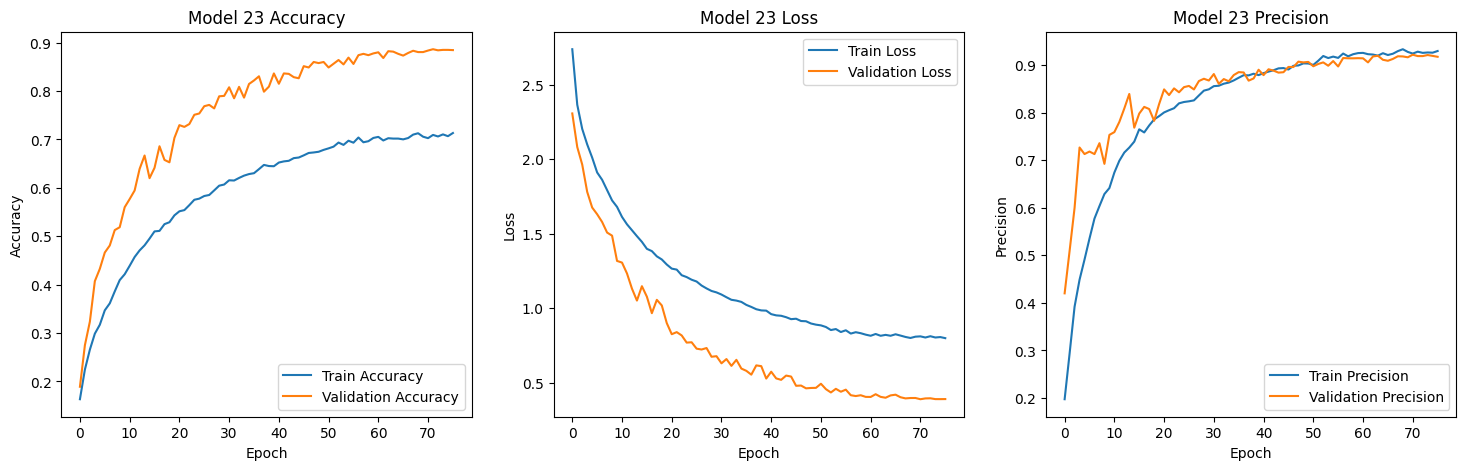

In [31]:
# to check for overfitting using accuracy

plt.figure(figsize=(18, 5))

# plot training & validation accuracy values over epoch

plt.subplot(1, 3, 1)
plt.plot(history_23_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_23_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 23 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# to check for overfitting using loss

# plot training & validation loss values over epoch
plt.subplot(1, 3, 2)
plt.plot(history_23_final.history['loss'], label='Train Loss')
plt.plot(history_23_final.history['val_loss'], label='Validation Loss')
plt.title('Model 23 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# plot training & validation loss values over epoch
plt.subplot(1, 3, 3)
plt.plot(history_23_final.history['precision'], label='Train Precision')
plt.plot(history_23_final.history['val_precision'], label='Validation Precision')
plt.title('Model 23 Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 98ms/step
23 x 23 base model confusion matrix :




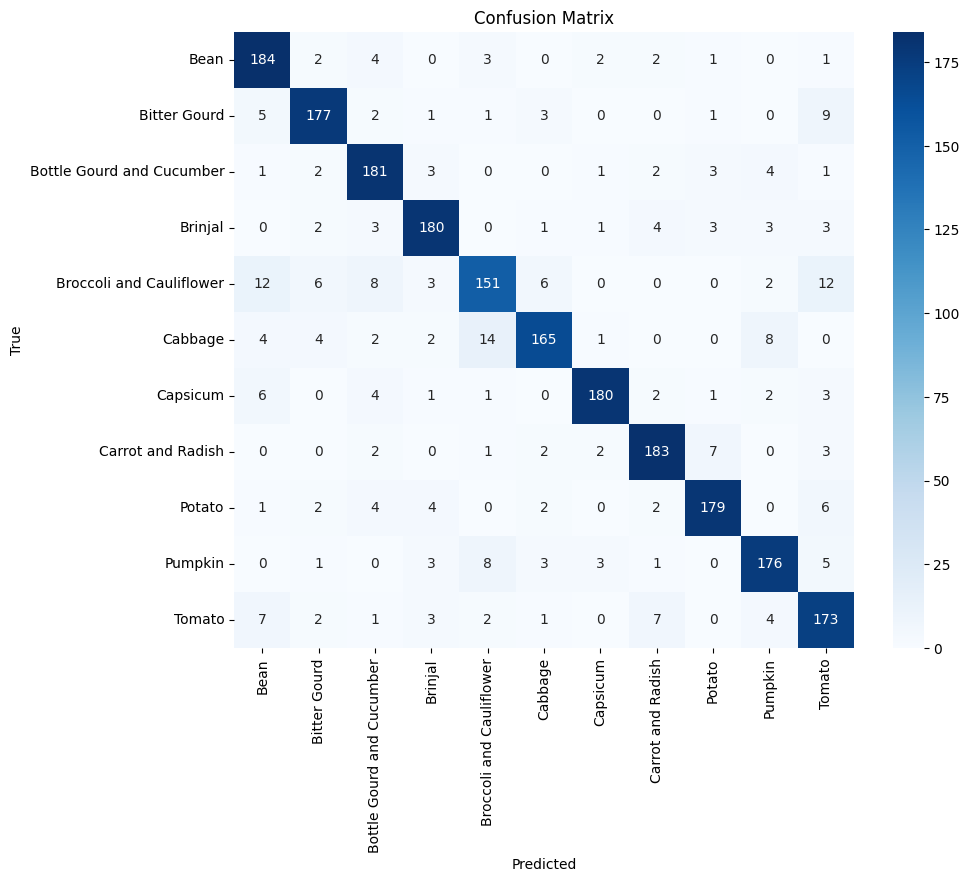

In [32]:
# confusion matrix to visualize 23 x 23 model's performance

# get predictions and true labels for the test set for 23 x 23 model
y_true_23_final, y_pred_23_final = get_predictions_and_labels(model_23_final, test_ds_23)  

# calculate the confusion matrix
cm_23_final = confusion_matrix(y_true_23_final, y_pred_23_final)

print('23 x 23 base model confusion matrix :\n\n')

# display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_23_final, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#

### **Model Summary**
###### - Model summary for final 23 model.

In [33]:
# viewing the model summary
model_23_final.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 23, 23, 64)        1664      
                                                                 
 batch_normalization_4 (Batc  (None, 23, 23, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 11, 11, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 32)        18464     
                                                                 
 batch_normalization_5 (Batc  (None, 11, 11, 32)      

#

# **Saving the class weights for 23x23 model.**
###### - Saving the best class weights for the final model in a h5 file.

In [34]:
# saving the weights
model_23_final.save_weights('model_23_final.h5')

#

# **Training 101x101 model**
###### - Training a base model. 
###### - This base model for 101 x 101 pixels has been experimented to perform quite well. 
###### - This is just a base, and will be improved after by hyperparameter tuning. 
###### - Setting up base model (conv blocks and layers), same as the previous 23 x 23 pixel models.
###### - Evaluating on test data. 
###### - **(This model is more complex than the 23x23 model as the data is more complex due to higher pixels, so model needs to be more complex as well)**

#

### **Base 101x101 model**
###### - This model was made to prevent / reduce overfitting as much as possible. 
###### - This is the end product after repeated experimenting to get the least overfitting model. 
###### - The parameters inside this model will not be hyperparameter tuned again.

In [35]:
# setting up the 101 model and its layers
# we use a more complex model with added layers compared to 23x23 model

# loading the sequential model
model_101 = Sequential()

# first conv block

# 2d conv layer, 64 filters, 5x5 kernel, relu activation, same padding, l2 regularization, input shape 101x101x1
model_101.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01), input_shape=(101, 101, 1)))

# batch normalization
model_101.add(BatchNormalization())

# max pooling, 2x2 pool size
model_101.add(MaxPooling2D(pool_size=(2, 2)))

# dropout, 0.1 dropout rate
model_101.add(Dropout(0.1)) 



# second conv block

# 2d conv layer, 64 filters, 5x5 kernel, relu activation, same padding
model_101.add(Conv2D(128, (5, 5), activation = 'relu', padding='same')) 

# batch normalization
model_101.add(BatchNormalization()) 

# max pooling, 2x2 pool size
model_101.add(MaxPooling2D(pool_size=(2, 2))) 

# dropout, 0.1 dropout rate
model_101.add(Dropout(0.1)) 



# third conv block

# 2d conv layer, 64 filters, 3x3 kernel, relu activation, same padding
model_101.add(Conv2D(64, (3, 3), activation = 'relu', padding='same')) 

# batch normalization
model_101.add(BatchNormalization()) 



# fourth conv block

# 2d conv layer, 32 filters, 3x3 kernel, relu activation, same padding
model_101.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# batch normalization
model_101.add(BatchNormalization())

# max pooling, 2x2 pool size
model_101.add(MaxPooling2D(pool_size=(2, 2)))

# dropout, 0.1 dropout rate
model_101.add(Dropout(0.1)) 



# fifth conv block

# 2d conv layer, 32 filters, 3x3 kernel, relu activation, same padding
model_101.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  

# batch normalization
model_101.add(BatchNormalization())



# flatten before dense layers

model_101.add(Flatten())



# first dense layer

# dense layer, 128 units, relu activation
model_101.add(Dense(128, activation='relu'))

# batch normalization
model_101.add(BatchNormalization())

# dropout, 0.1 dropout rate
model_101.add(Dropout(0.1)) 



# second dense layer

# dense layer, 128 units, relu activation
model_101.add(Dense(128, activation='relu'))

# batch normalization
model_101.add(BatchNormalization())

# dropout, 0.1 dropout rate
model_101.add(Dropout(0.1))



# output layer

# dense layer, 11 units (number of classes), softmax activation
model_101.add(Dense(11, activation='softmax'))



# compiling the model

model_101.compile(optimizer=Adam(learning_rate=0.0001), # adam optimizer, learning rate 0.0001
                 loss='categorical_crossentropy', # categorical crossentropy loss
                 metrics=['accuracy', 'Precision']) 

In [36]:
# fitting the model with early stopping and reduce lr on plateau 
# using train and validation data

# early stopping to stop the model before it overfits
early_stopping_101 = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# reduce_lr automatically decreases the learning rate during training when val_losee stops improving
# helps the optimizer to escape plateaus and fine-tune weights for better convergence
reduce_lr_101 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# fitting the model using 100 epochs and 100 batch_size
history_101 = model_101.fit(train_ds_101, epochs=100, validation_data=val_ds_101, verbose = 1, callbacks = [early_stopping_101, reduce_lr_101], batch_size = 32)

Epoch 1/100
329/329 [==============================] - 69s 72ms/step - loss: 2.1216 - accuracy: 0.3059 - precision: 0.5018 - val_loss: 1.5492 - val_accuracy: 0.4959 - val_precision: 0.6895 - lr: 1.0000e-04
Epoch 2/100
329/329 [==============================] - 67s 66ms/step - loss: 1.5042 - accuracy: 0.4892 - precision: 0.7398 - val_loss: 1.3567 - val_accuracy: 0.5627 - val_precision: 0.6983 - lr: 1.0000e-04
Epoch 3/100
329/329 [==============================] - 66s 67ms/step - loss: 1.2393 - accuracy: 0.5704 - precision: 0.8219 - val_loss: 0.8096 - val_accuracy: 0.7473 - val_precision: 0.8367 - lr: 1.0000e-04
Epoch 4/100
329/329 [==============================] - 68s 66ms/step - loss: 1.0888 - accuracy: 0.6267 - precision: 0.8721 - val_loss: 0.8887 - val_accuracy: 0.7341 - val_precision: 0.8330 - lr: 1.0000e-04
Epoch 5/100
329/329 [==============================] - 67s 68ms/step - loss: 0.9872 - accuracy: 0.6625 - precision: 0.8910 - val_loss: 0.5750 - val_accuracy: 0.8218 - val_preci

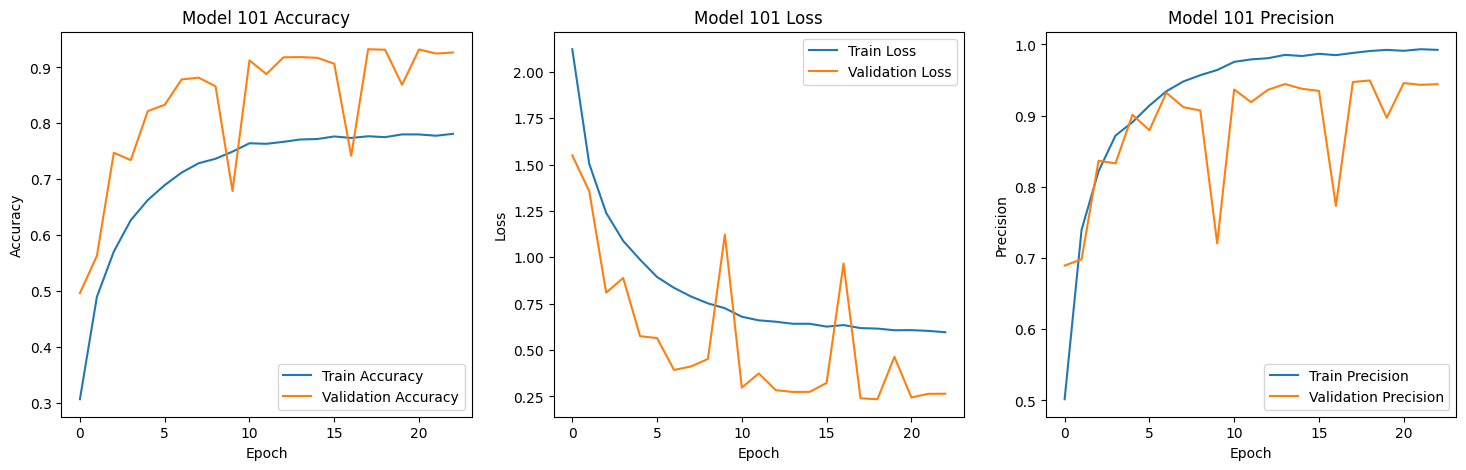

In [37]:
# to check for overfitting using accuracy

plt.figure(figsize=(18, 5))

# plot training & validation accuracy values over epoch

plt.subplot(1, 3, 1)
plt.plot(history_101.history['accuracy'], label='Train Accuracy')
plt.plot(history_101.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 101 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# to check for overfitting using loss

# plot training & validation loss values over epoch
plt.subplot(1, 3, 2)
plt.plot(history_101.history['loss'], label='Train Loss')
plt.plot(history_101.history['val_loss'], label='Validation Loss')
plt.title('Model 101 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# plot training & validation loss values over epoch
plt.subplot(1, 3, 3)
plt.plot(history_101.history['precision'], label='Train Precision')
plt.plot(history_101.history['val_precision'], label='Validation Precision')
plt.title('Model 101 Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 1s 597ms/step
101 x 101 base model confusion matrix :




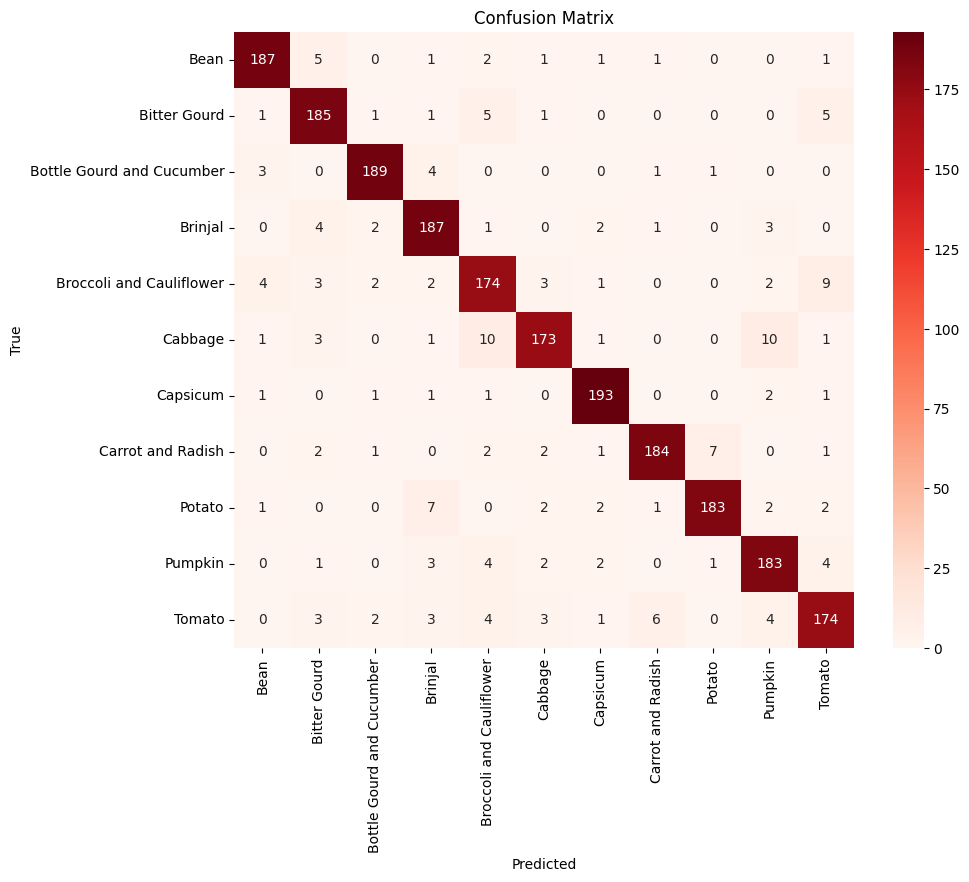

In [38]:
###############################################################
# confusion matrix to visualize 101 x 101 model's performance
###############################################################

# get predictions and true labels for the test set for 101 x 101 model
y_true_101_base, y_pred_101_base = get_predictions_and_labels(model_101, test_ds_101)  

# calculate the confusion matrix
cm_101 = confusion_matrix(y_true_101_base, y_pred_101_base)

print('101 x 101 base model confusion matrix :\n\n')

# display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_23, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# evaluating the model using test data
evaluation_results_base101 = model_101.evaluate(test_ds_101, verbose=1)

# printing the test results
print(f"\nTest Loss : {evaluation_results_base101[0]:.6f}")
print(f"Test Accuracy : {evaluation_results_base101[1] * 100:.3f}%")

69/69 [==============================] - 1s 18ms/step - loss: 0.2122 - accuracy: 0.9353 - precision: 0.9528

Test Loss : 0.212238
Test Accuracy : 93.534%


#

# **Hyperparameter tuning 101x101 model** 
###### - Hyperparameter tune the model now. 
###### - This is to get the best parameters for the model such that the model is trained the best and can achieve the best validation accuracy. 
###### - The best combination of parameters will be printed out and then used to evaluate the model on the train data.

In [40]:
# hyperparameter tuning the 101x101 model to get the best combination of hyperparameters to produce the best result

# define hyperparameter to experiment with
learning_rate_candidates_101 = [1e-3, 5e-3, 1e-4]
batch_size_candidates_101 = [32, 64, 128]  

# setting the first best hyperparameters and corresponding validation accuracy
best_val_accuracy_101 = 0.0
best_val_precision_101 = 0.0
best_val_loss_101 = float('inf')  # initialize with a very high value
best_learning_rate_101 = 0.0
best_batch_size_101 = 0.0  

# early stopping callback
early_stopping_101_tuning = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)  

LR: 0.001, Batch Size: 32, Validation Accuracy: 0.553636, Validation Loss: 2.310065, Validation Precision: 0.582795
1/1 [==============================] - 0s 193ms/step


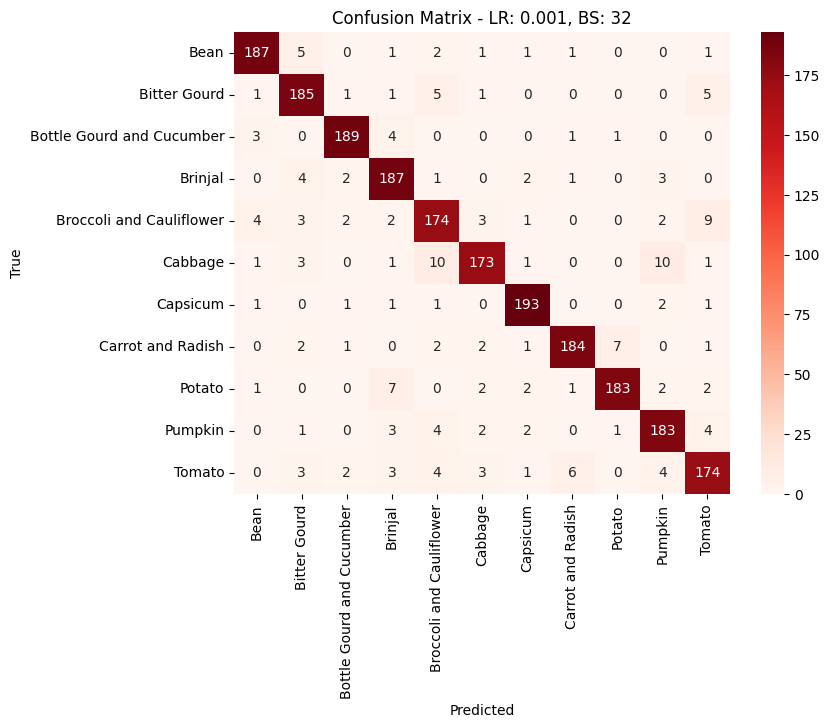

LR: 0.001, Batch Size: 64, Validation Accuracy: 0.529091, Validation Loss: 2.469339, Validation Precision: 0.557377
1/1 [==============================] - 0s 206ms/step


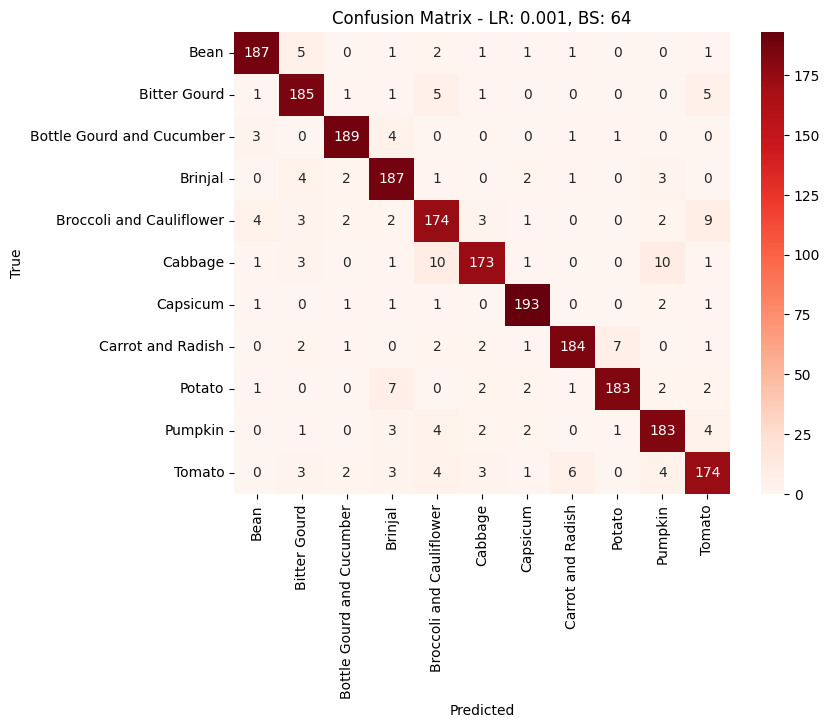

LR: 0.001, Batch Size: 128, Validation Accuracy: 0.195455, Validation Loss: 6.785029, Validation Precision: 0.198029
1/1 [==============================] - 0s 153ms/step


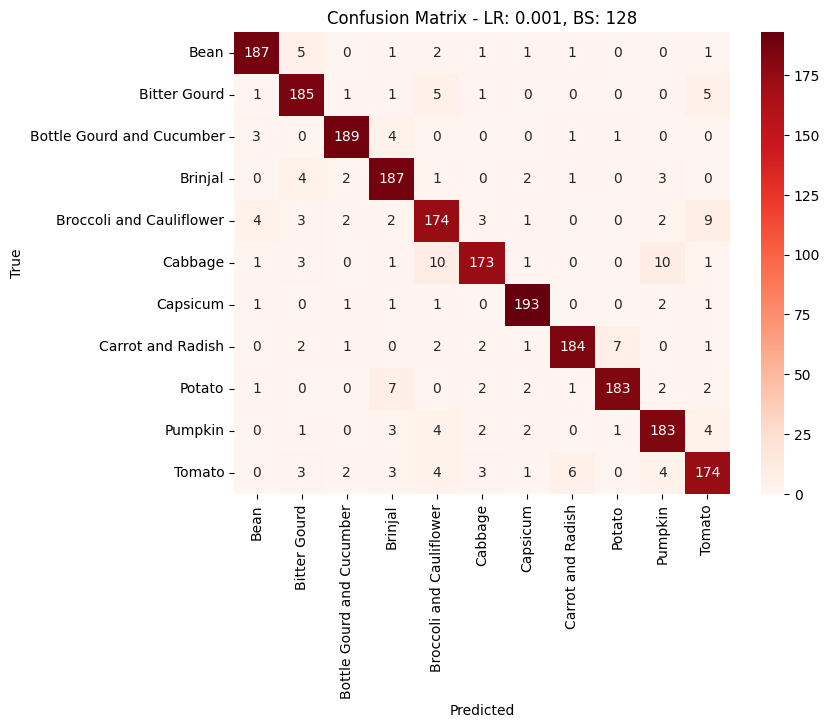

LR: 0.005, Batch Size: 32, Validation Accuracy: 0.136818, Validation Loss: 20.473572, Validation Precision: 0.138327
1/1 [==============================] - 0s 288ms/step


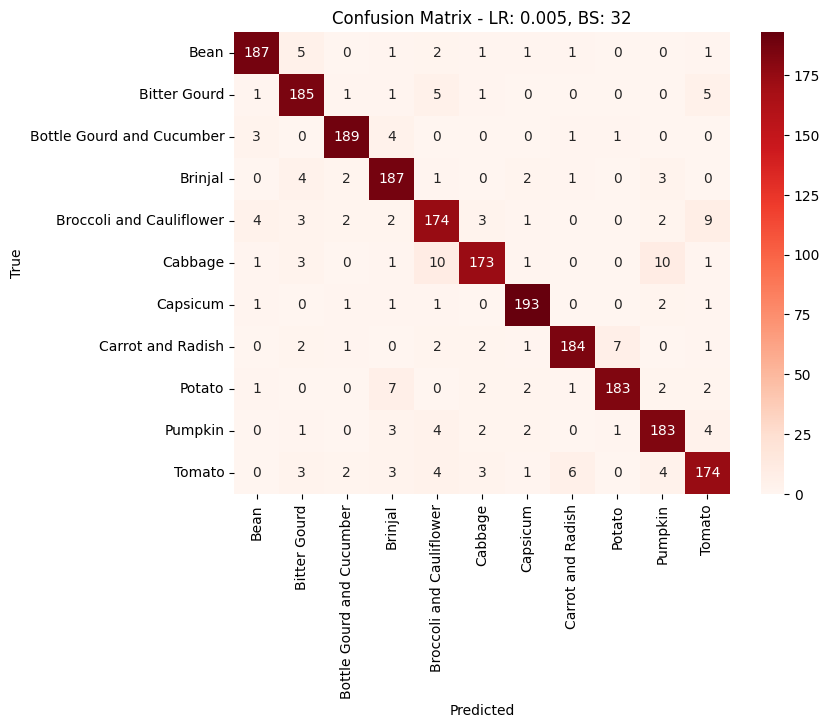

LR: 0.005, Batch Size: 64, Validation Accuracy: 0.161818, Validation Loss: 11.867029, Validation Precision: 0.165959
1/1 [==============================] - 0s 147ms/step


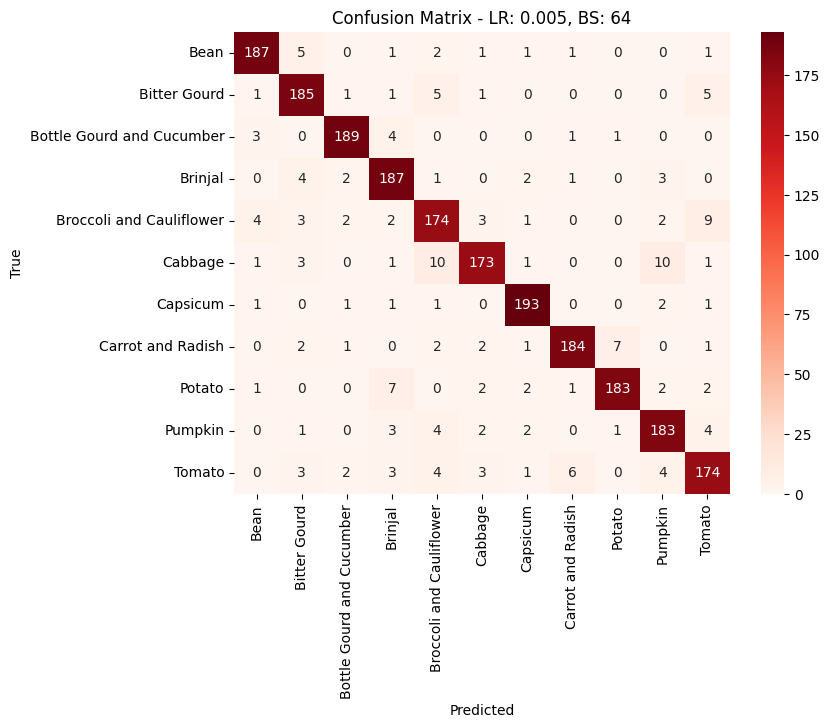

LR: 0.005, Batch Size: 128, Validation Accuracy: 0.326818, Validation Loss: 5.789595, Validation Precision: 0.331749
1/1 [==============================] - 0s 185ms/step


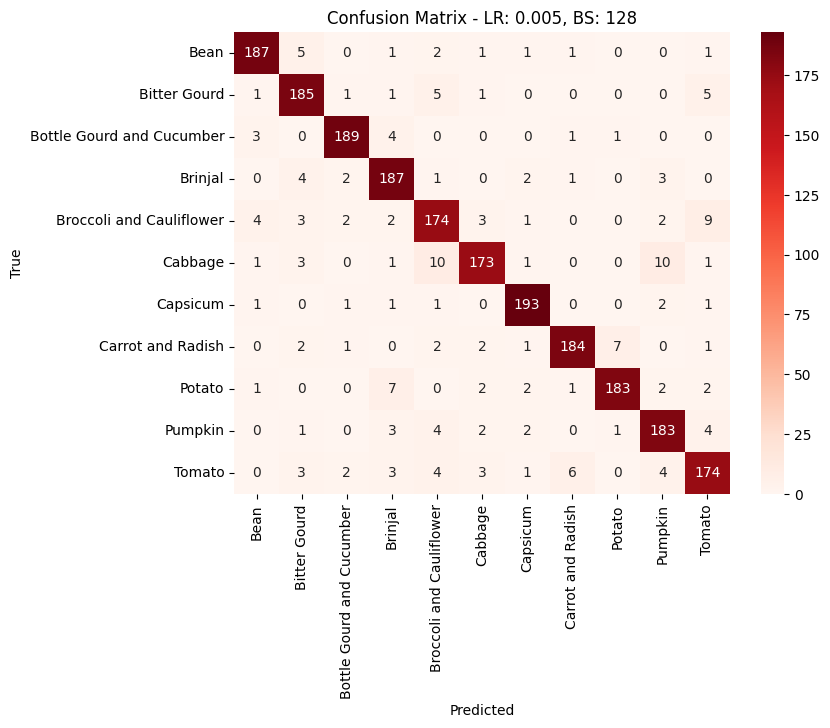

LR: 0.0001, Batch Size: 32, Validation Accuracy: 0.920455, Validation Loss: 0.303653, Validation Precision: 0.931241
1/1 [==============================] - 0s 147ms/step


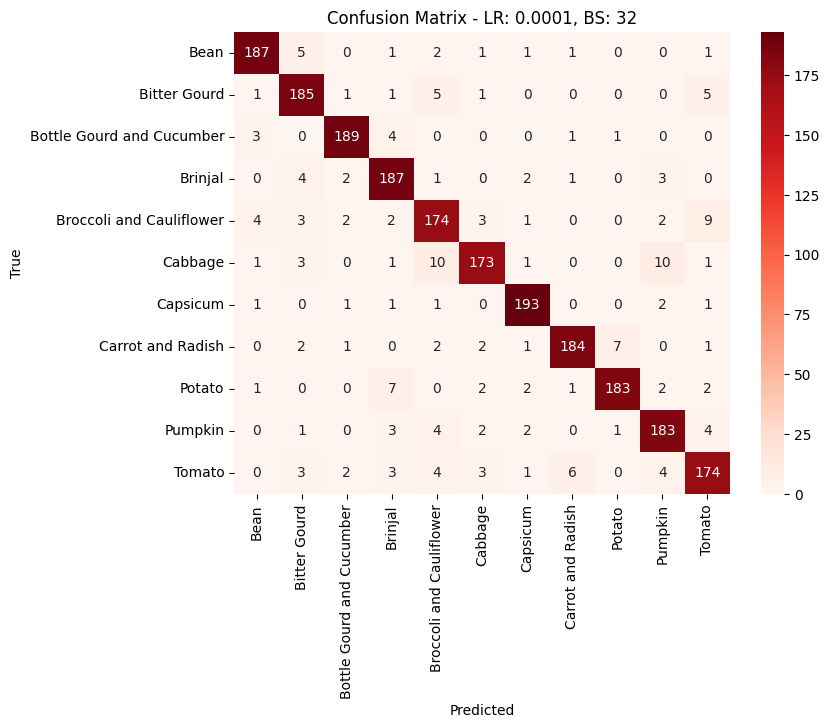

LR: 0.0001, Batch Size: 64, Validation Accuracy: 0.890909, Validation Loss: 0.431041, Validation Precision: 0.906803
1/1 [==============================] - 0s 159ms/step


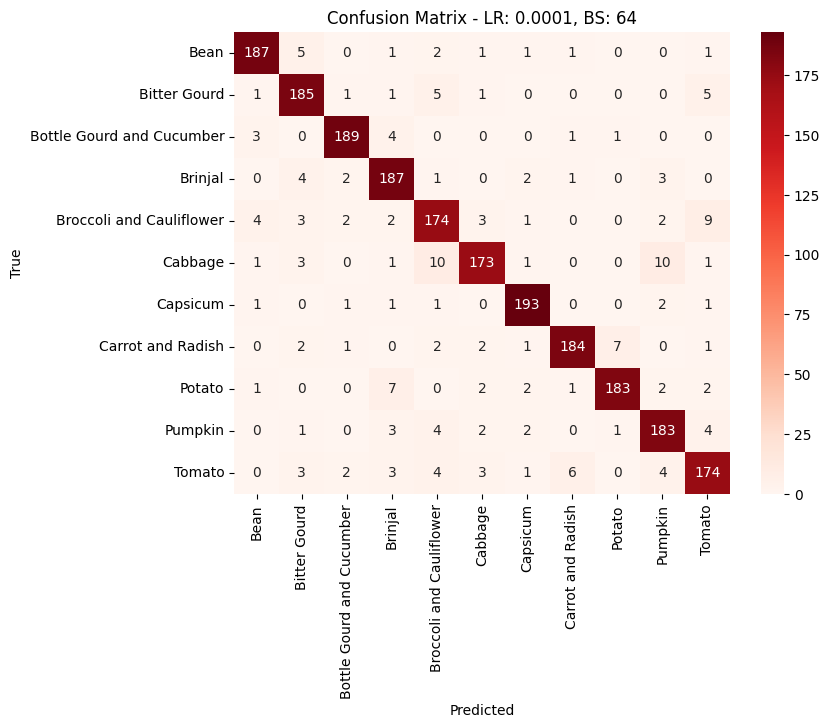

LR: 0.0001, Batch Size: 128, Validation Accuracy: 0.930909, Validation Loss: 0.282377, Validation Precision: 0.941774
1/1 [==============================] - 0s 157ms/step


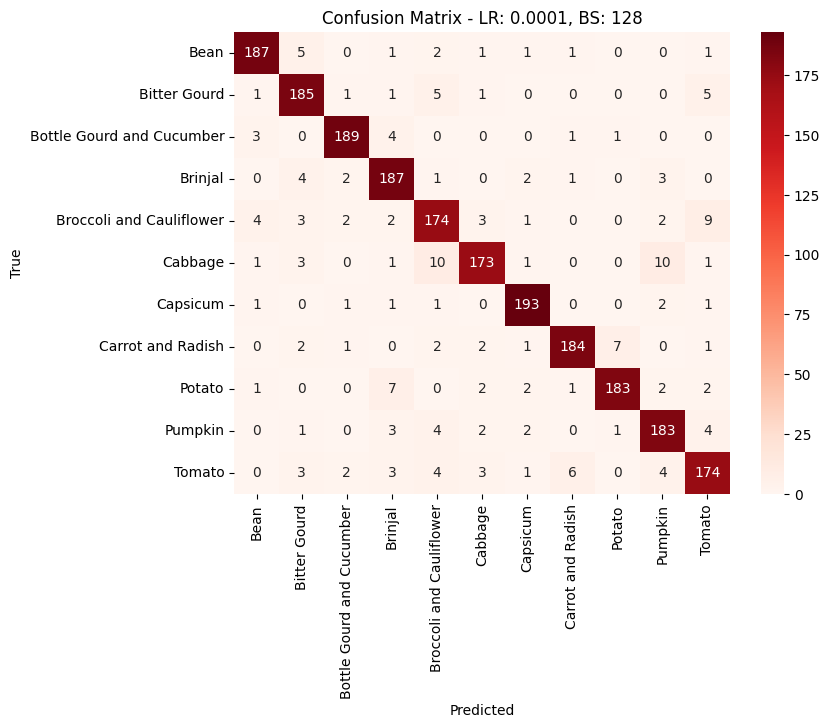


Best hyperparameters for 101 x 101 model :
Learning Rate: 0.0001
Batch Size: 128

Best Validation Accuracy: 0.930909
Best Validation Loss: 0.282377
Best Validation Precision: 0.941774


In [41]:
# now we iterate through hyperparameter combinations

for learning_rate in learning_rate_candidates_101:

    for batch_size in batch_size_candidates_101:

        # set optimizer to adam
        optimizer = Adam(learning_rate=learning_rate)

        # compile the model 
        model_101.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])

        # train the model
        history = model_101.fit(
            train_ds_101,
            epochs=100,  # 100 epochs used as there is early stopping
            validation_data=val_ds_101,
            verbose=0,
            callbacks=[early_stopping_101_tuning],
            batch_size=batch_size
        )

        # evaluate and store the best metrics
        val_loss = history.history['val_loss'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        val_precision = history.history['val_precision'][-1]

        # printing to monitor progress
        print(f"LR: {learning_rate}, Batch Size: {batch_size}, Validation Accuracy: {val_accuracy:.6f}, Validation Loss: {val_loss:.6f}, Validation Precision: {val_precision:.6f}")

        if val_loss < best_val_loss_101 and val_accuracy > best_val_accuracy_101 and val_precision > best_val_precision_101:
            best_val_accuracy_101 = val_accuracy
            best_val_loss_101 = val_loss
            best_val_precision_101 = val_precision
            best_learning_rate_101 = learning_rate
            best_batch_size_101 = batch_size

        # get predictions and true labels for the test set
        y_true_101, y_pred_101 = get_predictions_and_labels(model_101, test_ds_101)

        # calculate the confusion matrix
        cm_101_tuning = confusion_matrix(y_true_23_base, y_pred_23_base)

        # display the confusion matrix for each hyperparameter combination
        plt.figure(figsize=(8, 6))  
        sns.heatmap(cm_101_tuning, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - LR: {learning_rate}, BS: {batch_size}')  # Include parameters in title
        plt.show()


# print the best hyperparameters after finding out which of them produced the best accuracy

print("\nBest hyperparameters for 101 x 101 model :")
print(f"Learning Rate: {best_learning_rate_101}")
print(f"Batch Size: {best_batch_size_101}")
print(f"\nBest Validation Accuracy: {best_val_accuracy_101:.6f}")
print(f"Best Validation Loss: {best_val_loss_101:.6f}")
print(f"Best Validation Precision: {best_val_precision_101:.6f}")

#

# **Model Improvement (101)**
###### - We see that the final model is better at predicting some classes while for others it is not all that accurate.
###### - Since this problem was present even during hyperparameter tuning, the issue doesnt come from the model. 
###### - We will try using class weights to solve the issue.
###### - Class weighting rebalances the importance of each sample during the model's training process.
###### - This shifts the model's focus. 
###### - By making errors on minority classes more impactful, the model is forced to pay more attention to learning the distinguishing features of these classes. 
###### - This makes it such that it can no longer "ignore" them to minimize overall loss.
###### - This is the same way the 23x23 model is improved.

In [42]:
# 1) extract integer labels from training dataset

print("Extracting integer labels from train_ds_101 for class weight calculation...\n")

y_train_labels = []

for images, labels in train_ds_101.unbatch(): # unbatch to get individual samples
    y_train_labels.append(tf.argmax(labels).numpy()) # convert one-hot to integer label

y_train_labels = np.array(y_train_labels)
print(f"Finished extracting {len(y_train_labels)} labels.\n")


# 2) calculate class weights

# 'balanced' mode automatically computes weights inversely proportional to class frequencies
# this assigns higher weights to less frequent classes

print("Calculating class weights...\n")

unique_classes = np.unique(y_train_labels)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_labels
)

class_weights_dict_101 = dict(enumerate(class_weights_array))
print("Class weights calculated:", class_weights_dict_101)

# now we evaluate our final model to see if this issue is fixed

Extracting integer labels from train_ds_101 for class weight calculation...

Finished extracting 10505 labels.

Calculating class weights...

Class weights calculated: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}


#

# **Evaluating 101x101 model**
###### - Fitting the model one last time with best parameters after determining which they are. 
###### - The model will then be evaluated on the test data. 
###### - The model will be evaluated on its test accuracy and confusion matrix. 
###### - A loss over epochs line chart will also be plotted for visualisation to see if there's any overfitting.

#

### **Function to create model (101x101)**
###### - We define the model creation function to create our final model with ease.
###### - The model uses same layers and parameters as the base model.

In [43]:
# create_model function to be used for both 23x23 model after hyperparameter tuning to create final model

# this function is for 101 x 101 model as the input shape is (101, 101, 1)

def create_model_101():
    
    model = Sequential()

    # first conv block
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01), input_shape=(101, 101, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    # second conv block
    model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    # third conv block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    # fourth conv block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    # fifth conv block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Changed to 32 filters
    model.add(BatchNormalization())

    # flatten before dense layers
    model.add(Flatten())

    # first dense layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # second dense layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # output layer
    model.add(Dense(11, activation='softmax'))

    return model

### - **Now we create the final 101x101 model.**

#

In [44]:
# create and train the final model with the best hyperparameters

# create model with best dropout using written function above
model_101_final = create_model_101() 

# define optimizer
final_optimizer = Adam(learning_rate=best_learning_rate_101) 

# compiling the final model
model_101_final.compile(optimizer=final_optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])

# set up early stopping with patience = 5
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# set up reducelronplateau
reduce_lr_101 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# train the model with the best hyperparameters
history_101_final = model_101_final.fit(
    train_ds_101,
    epochs=100,  
    validation_data=val_ds_101,
    verbose=1,  
    callbacks=[early_stopping, reduce_lr_101],
    batch_size=best_batch_size_101
)

# evaluate the model on the test set
test_loss_101, test_accuracy_101, test_precision_101 = model_101_final.evaluate(test_ds_101, verbose=1)

# print results
print("\nTest Results:")
print(f"Test Loss: {test_loss_101:.6f}")
print(f"Test Accuracy: {test_accuracy_101 * 100:.3f}%")
print(f"Test Precision: {test_precision_101 * 100:.3f}%")

Epoch 1/100
329/329 [==============================] - 82s 69ms/step - loss: 2.0567 - accuracy: 0.3183 - precision: 0.5130 - val_loss: 1.4016 - val_accuracy: 0.5555 - val_precision: 0.7921 - lr: 1.0000e-04
Epoch 2/100
329/329 [==============================] - 82s 68ms/step - loss: 1.4770 - accuracy: 0.4994 - precision: 0.7548 - val_loss: 1.3436 - val_accuracy: 0.5541 - val_precision: 0.6867 - lr: 1.0000e-04
Epoch 3/100
329/329 [==============================] - 80s 70ms/step - loss: 1.2234 - accuracy: 0.5804 - precision: 0.8296 - val_loss: 0.7834 - val_accuracy: 0.7614 - val_precision: 0.8608 - lr: 1.0000e-04
Epoch 4/100
329/329 [==============================] - 81s 69ms/step - loss: 1.0732 - accuracy: 0.6329 - precision: 0.8803 - val_loss: 0.6452 - val_accuracy: 0.8009 - val_precision: 0.8791 - lr: 1.0000e-04
Epoch 5/100
329/329 [==============================] - 81s 71ms/step - loss: 0.9591 - accuracy: 0.6704 - precision: 0.9063 - val_loss: 0.8783 - val_accuracy: 0.7132 - val_preci

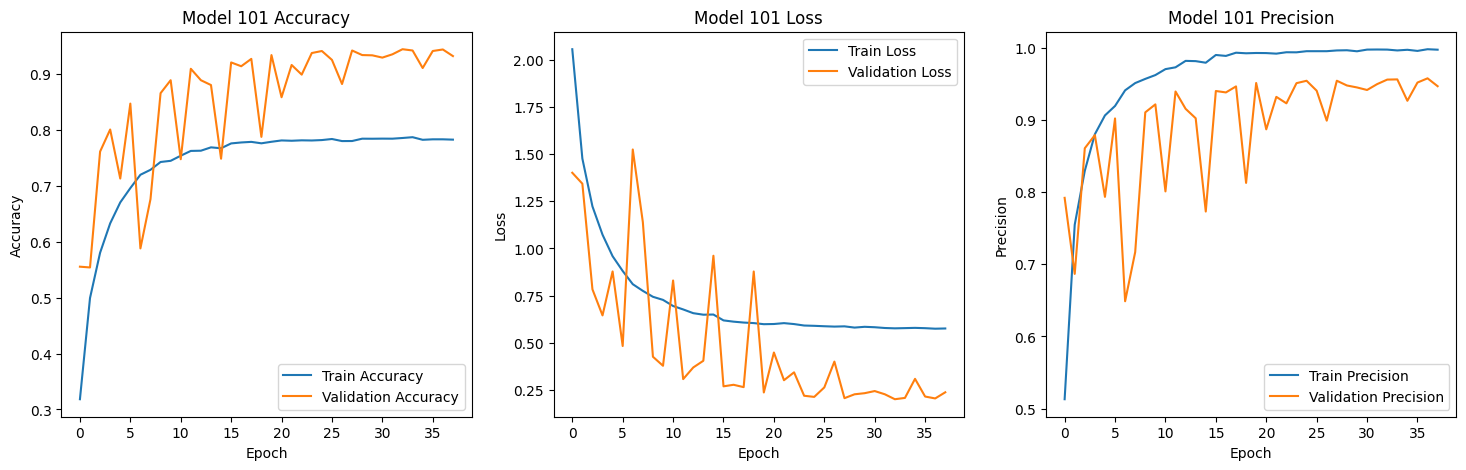

In [45]:
# to check for overfitting using accuracy

plt.figure(figsize=(18, 5))

# plot training & validation accuracy values over epoch

plt.subplot(1, 3, 1)
plt.plot(history_101_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_101_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 101 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# to check for overfitting using loss

# plot training & validation loss values over epoch
plt.subplot(1, 3, 2)
plt.plot(history_101_final.history['loss'], label='Train Loss')
plt.plot(history_101_final.history['val_loss'], label='Validation Loss')
plt.title('Model 101 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# plot training & validation loss values over epoch
plt.subplot(1, 3, 3)
plt.plot(history_101_final.history['precision'], label='Train Precision')
plt.plot(history_101_final.history['val_precision'], label='Validation Precision')
plt.title('Model 101 Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 21ms/step
101 x 101 models confusion matrix :




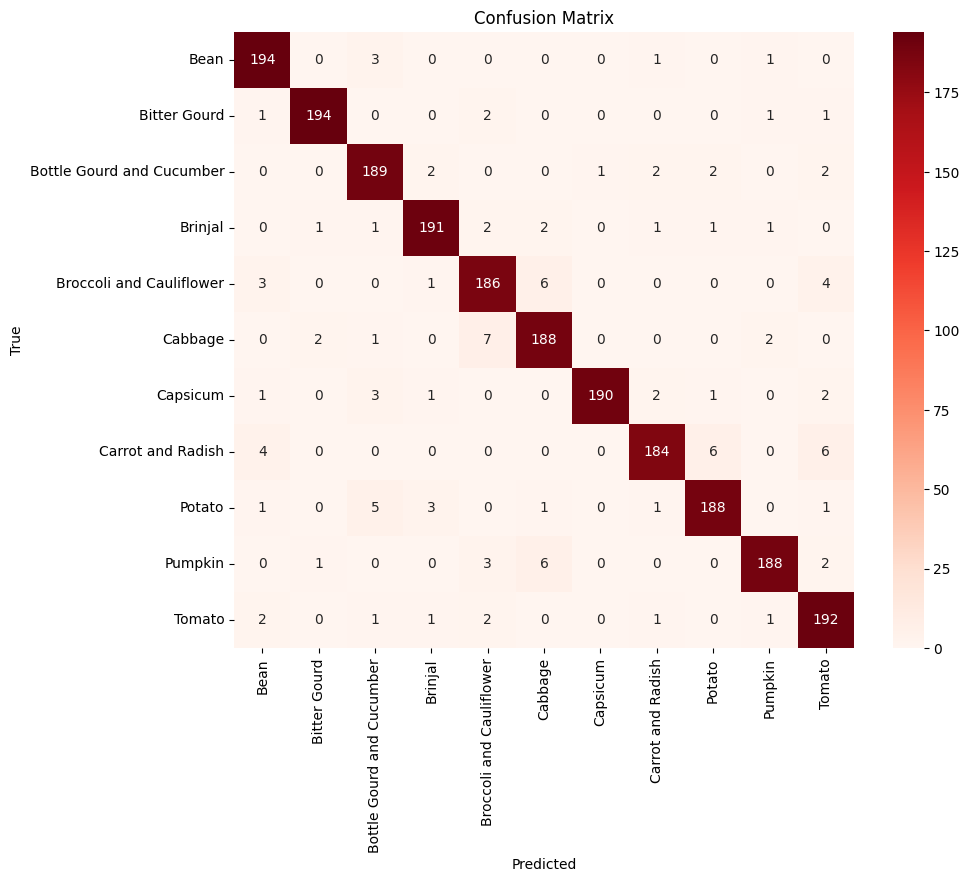

In [52]:
###############################################################
# confusion matrix to visualize 101 x 101 model's performance
###############################################################

# get predictions and true labels for the test set for 101 x 101 model
y_true_101, y_pred_101 = get_predictions_and_labels(model_101_final, test_ds_101)  

# calculate the confusion matrix
cm_101 = confusion_matrix(y_true_101, y_pred_101)

print('101 x 101 models confusion matrix :\n\n')

# display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_101, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#

### **Model Summary**
###### - Model summary for final 101 model.

In [46]:
# viewing the model summary
model_101_final.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 101, 101, 64)      1664      
                                                                 
 batch_normalization_15 (Bat  (None, 101, 101, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 128)       204928    
                                                                 
 batch_normalization_16 (Bat  (None, 50, 50, 128)     

#

# **Saving the class weights for 101x101 model.**
###### - Saving the best class weights for the final model in a h5 file.

In [47]:
# saving the weights
model_101_final.save_weights('model_101_final.h5')

#

# **Evaluating / Comparing both models (23x23 and 101x101)**
###### - Both models will be evaluated and compared here. 
###### - Both their test accuracies, confusion matrix and model summary will be displayed here, next to each other. 
###### - This allows for quick and easy visualisation of the differences for both these models. 

#

### **Confusion Matrix**
###### - Confusion matrix is shown again for both final models to compare performance.

1/1 [==============================] - 0s 49ms/step


23 x 23 models confusion matrix :




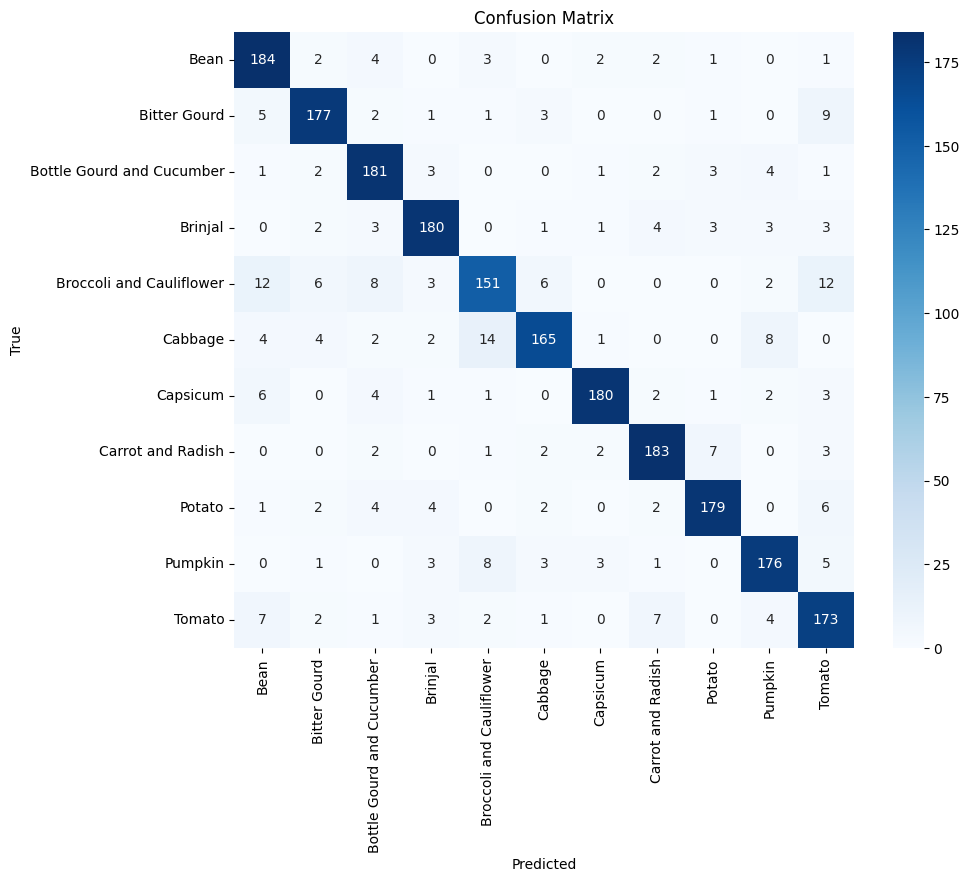

In [48]:
###############################################################
# confusion matrix to visualize 23 x 23 model's performance
###############################################################

# get predictions and true labels for the test set for 23x23 model
y_true_23, y_pred_23 = get_predictions_and_labels(model_23_final, test_ds_23)  

# calculate the confusion matrix
cm_23 = confusion_matrix(y_true_23, y_pred_23)

print('\n\n23 x 23 models confusion matrix :\n\n')

# display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_23, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 198ms/step
101 x 101 models confusion matrix :




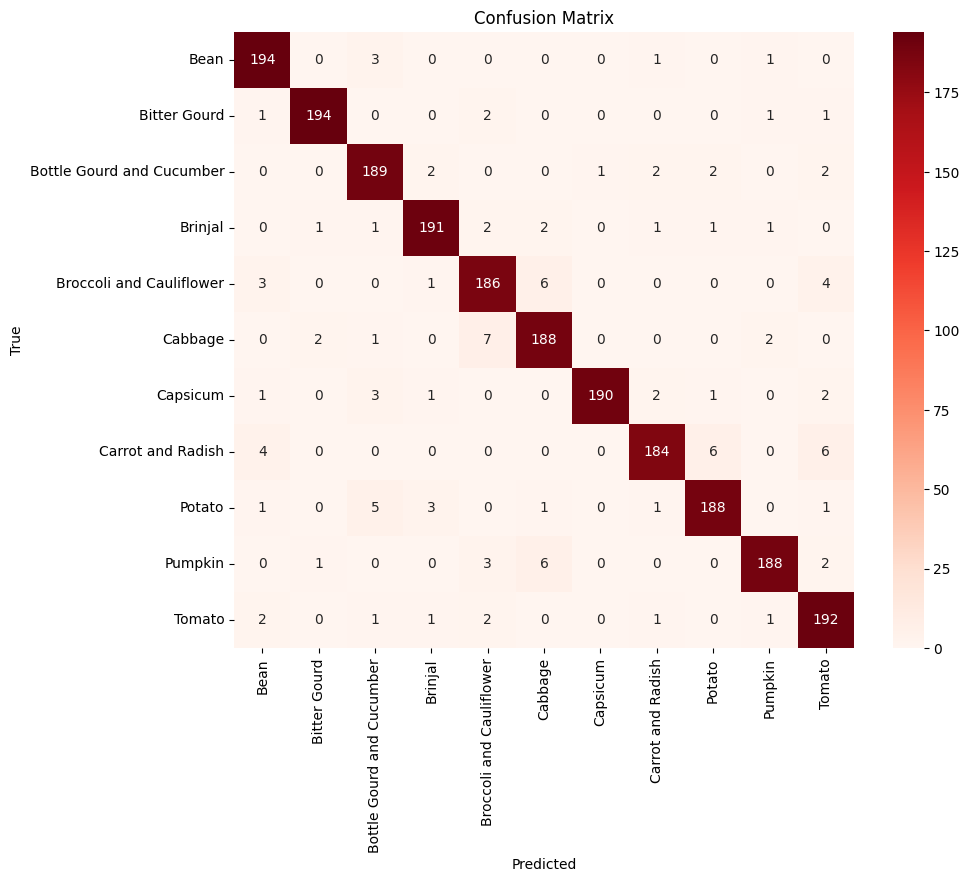

In [49]:
###############################################################
# confusion matrix to visualize 101 x 101 model's performance
###############################################################

# get predictions and true labels for the test set for 101 x 101 model
y_true_101, y_pred_101 = get_predictions_and_labels(model_101_final, test_ds_101)  

# calculate the confusion matrix
cm_101 = confusion_matrix(y_true_101, y_pred_101)

print('101 x 101 models confusion matrix :\n\n')

# display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_101, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#

### **Classification Report**
###### - Used to view the precision, recall, f1-score and support for the model's predictions in all classes.

In [50]:
###############################################################
# viewing the classification report for the 23 x 23 model 
###############################################################

# get predictions
predictions_23 = model_23_final.predict(test_ds_23)
predicted_labels_23 = np.argmax(predictions_23, axis=1)

# get true labels
true_labels_23 = []
for images, labels in test_ds_23:
    true_labels_23.extend(np.argmax(labels, axis=1))
true_labels_23 = np.array(true_labels_23)

# generate the classification report 
report_23 = classification_report(true_labels_23, predicted_labels_23, target_names=class_names)

# show the report
print('\n\nClassification report for 23 x 23 model :\n\n')
print(report_23)

69/69 [==============================] - 1s 8ms/step


Classification report for 23 x 23 model :


                           precision    recall  f1-score   support

                     Bean       0.84      0.92      0.88       199
             Bitter Gourd       0.89      0.89      0.89       199
Bottle Gourd and Cucumber       0.86      0.91      0.89       198
                  Brinjal       0.90      0.90      0.90       200
 Broccoli and Cauliflower       0.83      0.76      0.79       200
                  Cabbage       0.90      0.82      0.86       200
                 Capsicum       0.95      0.90      0.92       200
        Carrot and Radish       0.90      0.92      0.91       200
                   Potato       0.92      0.90      0.91       200
                  Pumpkin       0.88      0.88      0.88       200
                   Tomato       0.80      0.86      0.83       200

                 accuracy                           0.88      2196
                macro avg   

In [51]:
###############################################################
# viewing the classification report for the 101 x 101 model 
###############################################################

# get predictions
predictions_101 = model_101_final.predict(test_ds_101)
predicted_labels_101 = np.argmax(predictions_101, axis=1)

# get true labels
true_labels_101 = []
for images, labels in test_ds_101:
    true_labels_101.extend(np.argmax(labels, axis=1))
true_labels_101 = np.array(true_labels_101)

# generate the classification report 
report_101 = classification_report(true_labels_101, predicted_labels_101, target_names=class_names)

# show the report
print('\n\nClassification report for 101 x 101 model :\n\n')
print(report_101)

69/69 [==============================] - 1s 15ms/step


Classification report for 101 x 101 model :


                           precision    recall  f1-score   support

                     Bean       0.94      0.97      0.96       199
             Bitter Gourd       0.98      0.97      0.98       199
Bottle Gourd and Cucumber       0.93      0.95      0.94       198
                  Brinjal       0.96      0.95      0.96       200
 Broccoli and Cauliflower       0.92      0.93      0.93       200
                  Cabbage       0.93      0.94      0.93       200
                 Capsicum       0.99      0.95      0.97       200
        Carrot and Radish       0.96      0.92      0.94       200
                   Potato       0.95      0.94      0.94       200
                  Pumpkin       0.97      0.94      0.95       200
                   Tomato       0.91      0.96      0.94       200

                 accuracy                           0.95      2196
                macro avg

#

# **Conclusion**
###### - Which model performed better? 
###### - Why is that so? 
###### - Is the difference in performance big? 
###### - Were there any unexpected results? 
###### - Did my models overfit?
###### - Did models get better after hyperparameter tuning?

#

We can see that the final models 23x23 and 101x101 pixels, the 101 is performing better with lower loss and higher accuracy. This is expected as logically speaking, it is easier to classify data if the data is clearer, so the model with clearer photos (101x101 pixels) is expected to perform better. However, this also makes the data more complex so the model should be tuned to fit the complexity of the data properly, We can also see that there are less false positives in the 101x101 model compared to the 23x23 model, suggesting the 101x101 performed much better than the 23x23 model. 



#

# **THE END**